# Imports 

In [1]:
from pybaseball import statcast, statcast_batter, playerid_lookup, playerid_reverse_lookup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

import pygam
from pygam import LogisticGAM, s, f

from pprint import pprint

import pickle
import joblib

import itertools
import warnings
import logging

#logging.basicConfig(level=logging.DEBUG)
#logging.basicConfig(level=logging.ERROR)

%run models.py
%run ../src/data_helpers.py
%run ../src/plot_helpers.py
%run ../src/xgboost_model_helpers.py
%run ../src/mlflow_pipeline_helpers.py

np.random.seed(909)
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [2]:
# Read in Statcast data (cleaned and transformed)
data2023 = pd.read_csv("/Users/josh/Documents/Baseball/Statcast/data23_trf.csv", low_memory = True)
data2024 = pd.read_csv("/Users/josh/Documents/Baseball/Statcast/data24_trf.csv", low_memory = True)
data2025 = pd.read_csv("/Users/josh/Documents/Baseball/Statcast/data25_trf.csv", low_memory = True)

sort_cols = ["game_year", "game_date", "game_pk", "at_bat_number", "pitch_number"]

data_concat = pd.concat([data2023, data2024], axis = 0).sort_values(sort_cols).reset_index(drop=True).dropna(subset=["arm_angle"])

data2025 = data2025.sort_values(sort_cols).reset_index(drop=True).dropna(subset=["arm_angle"])

In [3]:
data_concat_diff = add_diff_features(data_concat)

data2025_diff = add_diff_features(data2025)

# Modeling

## Setup

In [27]:
# Terminal Command prior to running below code (not in notebook): mlflow server --host 127.0.0.1 --port 8080
localhost_url = "http://127.0.0.1:8080/"
mlflow.set_tracking_uri(uri= localhost_url)

In [28]:
client = MlflowClient(tracking_uri= localhost_url)

all_experiments = client.search_experiments()
print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/724063170462233953', creation_time=1751081636821, experiment_id='724063170462233953', last_update_time=1751081638979, lifecycle_stage='active', name='P(EV Bucket) Stuff', tags={'mlflow.note.content': 'This is the P(Exit Velocity Bucket) predictive '
                        'modeling task under the Stuff+ project. This '
                        'experiment contains the models built for modeling '
                        'fair ball probability given contact (P(Fair) >= 0.5).',
 'project_name': 'p-ev-prs',
 'project_quarter': 'Q2-2025',
 'team': 'josh-stuff'}>, <Experiment: artifact_location='mlflow-artifacts:/995281553230585235', creation_time=1751079074156, experiment_id='995281553230585235', last_update_time=1751079076194, lifecycle_stage='active', name='P(Launch Angle Bucket) Stuff', tags={'mlflow.note.content': 'This is the P(Launch Angle Bucket) predictive '
                        'modeling task under the Stuff+ project. This '
   

## P(Swing)

In [6]:
"""
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the P(Swing) predictive modeling task under the Stuff+ project. "
    "This experiment contains the models built for modeling swing probability"
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "p-swing-stuff",
    "team": "josh-stuff",
    "project_quarter": "Q2-2025",
    "mlflow.note.content": experiment_description,
}

experiment_name = "P(Swing) Models"

# Create the Experiment, providing a unique name
p_swing_experiment = client.create_experiment(
    name= experiment_name, tags=experiment_tags
)
""" 

' '

In [29]:
# Use search_experiments() to search on the project_name tag key
swing_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'p-swing-stuff'"
)

swing_experiment_id =  vars(swing_experiment[0])["_experiment_id"]

In [30]:
swing_experiment_id

'211496464776315993'

In [31]:
client.delete_experiment(swing_experiment_id)
client.restore_experiment(swing_experiment_id)

experiment = client.get_experiment(swing_experiment_id)
experiment

<Experiment: artifact_location='mlflow-artifacts:/211496464776315993', creation_time=1750900633272, experiment_id='211496464776315993', last_update_time=1751118079839, lifecycle_stage='active', name='P(Swing) Stuff', tags={'mlflow.note.content': 'This is the P(Swing) predictive modeling task under '
                        'the Stuff+ project. This experiment contains the '
                        'models built for modeling swing probability given '
                        'contact (P(Swing) >= 0.5).',
 'project_name': 'p-swing-stuff',
 'project_quarter': 'Q2-2025',
 'team': 'josh-stuff'}>

In [32]:
diff_features = ['effective_speed_diff', 'pfx_x_diff', 'pfx_z_diff']

In [39]:
# Get P(Swing) Data
p_swing_model_data = get_pitch_outcome_features(data_concat_diff, model_type= "swing_stuff", added_features = diff_features)
data_predict_swing = get_pitch_outcome_features(data2025_diff, model_type= "swing_stuff", added_features = diff_features)

response_col = "Swing_Event"
info_cols = ["batter", "pitcher", "game_year", "game_date", response_col]

data_predict_swing_X = data_predict_swing.drop(info_cols, axis = 1)

pyfunc_model_path = "../tmp/p_swing_stuff_diffs_xgb"

p_swing_X = p_swing_model_data.drop(info_cols, axis = 1)
p_swing_y = p_swing_model_data[response_col]

X_train, X_valid, y_train, y_valid = train_test_split(p_swing_X, p_swing_y)

In [40]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((970330, 14), (970330,), (323444, 14), (323444,))

Name the project/task itself:  P(Swing) with Diffs
Choose problem type (classification/regression):  classification
Choose if Multiclass or Binary (Multiclass/Binary):  Binary
Choose if Probability Calibration is needed or not (Yes/No):  Yes
Choose Probability Calibration Method (Sigmoid/Isotonic):  Sigmoid
Choose model (XGBClassifier, LGBMClassifier, XGB-DMatrix, RandomForestClassifier, LogisticRegression):  XGBClassifier
Give all child run's artifact path:  model
Give the parent run it's own name:  P(Swing) v Diffs
Give the final model artifact's name:  final
Specify the number of trials to run with Optuna:  20


[I 2025-06-28 09:57:45,107] A new study created in memory with name: no-name-93c6388b-6f3e-4c9a-b1eb-f0bb15fc3246


Creating Optuna study...


[I 2025-06-28 09:58:14,107] Trial 0 finished with value: 0.611322719531452 and parameters: {'n_estimators': 309, 'eta': 0.27321142143194327, 'gamma': 0.00024381241934718492, 'max_depth': 3, 'min_child_weight': 1, 'lambda': 0.44834762277523715, 'alpha': 1.9976089180468126, 'subsample': 0.8052202617037116, 'colsample_bytree': 0.8312788978088912}. Best is trial 0 with value: 0.611322719531452.


🏃 View run debonair-dolphin-716 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/0b80b19954564119a2954dbf8b7f75d2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:00:23,109] Trial 1 finished with value: 0.612247040362013 and parameters: {'n_estimators': 1883, 'eta': 0.034603793908305154, 'gamma': 0.0018315426338551227, 'max_depth': 5, 'min_child_weight': 6, 'lambda': 0.0003279187740553112, 'alpha': 0.04557676570302858, 'subsample': 0.3978403643990354, 'colsample_bytree': 0.4213544302005753}. Best is trial 0 with value: 0.611322719531452.


🏃 View run delicate-shad-84 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/20196a708ab24439a45ad066061846ad
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:01:11,704] Trial 2 finished with value: 0.6045701716319619 and parameters: {'n_estimators': 1619, 'eta': 0.20921606095581716, 'gamma': 4.644704614751417e-05, 'max_depth': 6, 'min_child_weight': 4, 'lambda': 0.013828404851079591, 'alpha': 3.717133551624683e-05, 'subsample': 0.9146983847171903, 'colsample_bytree': 0.8227512729631741}. Best is trial 2 with value: 0.6045701716319619.


🏃 View run thundering-smelt-759 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/fdbba265f99947d7822cff6901383267
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:02:29,463] Trial 3 finished with value: 0.6112895255031545 and parameters: {'n_estimators': 1425, 'eta': 0.05012618231400253, 'gamma': 0.00027999443856700795, 'max_depth': 3, 'min_child_weight': 10, 'lambda': 0.03221634025755784, 'alpha': 0.00032141971442522176, 'subsample': 0.6828668078018039, 'colsample_bytree': 0.9872171645434658}. Best is trial 2 with value: 0.6045701716319619.


🏃 View run silent-rat-744 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/8bf328058f1048a580001ab6ad02a6c4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:04:17,642] Trial 4 finished with value: 0.6021528730034028 and parameters: {'n_estimators': 1110, 'eta': 0.03120198136233189, 'gamma': 0.1865265757628608, 'max_depth': 9, 'min_child_weight': 3, 'lambda': 0.07214477804939573, 'alpha': 0.026182604690906507, 'subsample': 0.9001237716181578, 'colsample_bytree': 0.7094148345877203}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run capable-croc-679 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/be6358653c66499698aa74d4ec40aa96
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:04:44,171] Trial 5 finished with value: 0.6328756122524991 and parameters: {'n_estimators': 315, 'eta': 0.03535461996397859, 'gamma': 0.30779237796479514, 'max_depth': 5, 'min_child_weight': 6, 'lambda': 0.0007795156410032828, 'alpha': 1.061707060588907e-05, 'subsample': 0.7999260988846376, 'colsample_bytree': 0.3685269273276952}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run persistent-frog-902 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/959a4c1fc8f140b0b613d5005d5de40a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:06:26,312] Trial 6 finished with value: 0.6084431889656274 and parameters: {'n_estimators': 1060, 'eta': 0.012000943209644286, 'gamma': 0.001078620176951987, 'max_depth': 8, 'min_child_weight': 10, 'lambda': 1.0525254549512967e-05, 'alpha': 0.00012887333713537842, 'subsample': 0.8962056391654285, 'colsample_bytree': 0.7993540959858343}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run rebellious-wasp-317 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/69a55eea61ca4f94b52971f68f3a3e15
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:08:38,071] Trial 7 finished with value: 0.6075727568729973 and parameters: {'n_estimators': 1332, 'eta': 0.013942050503531814, 'gamma': 0.01790899902084269, 'max_depth': 8, 'min_child_weight': 9, 'lambda': 0.6432044201706508, 'alpha': 9.571376303017596, 'subsample': 0.4953297849136058, 'colsample_bytree': 0.8487449057528742}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run beautiful-conch-153 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/9808a23bc37a49a1b8912405a5aea931
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:09:47,490] Trial 8 finished with value: 0.6119357097277666 and parameters: {'n_estimators': 936, 'eta': 0.04798472936165505, 'gamma': 2.810690761844975, 'max_depth': 8, 'min_child_weight': 5, 'lambda': 0.27139525374492607, 'alpha': 4.727398352489427, 'subsample': 0.38835077980759736, 'colsample_bytree': 0.30004222535022235}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run learned-boar-128 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/536bfb758a3f4573bc0ec8916c4a987d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:10:28,303] Trial 9 finished with value: 0.6200662789141063 and parameters: {'n_estimators': 668, 'eta': 0.1341474397564621, 'gamma': 0.004430676305942079, 'max_depth': 2, 'min_child_weight': 7, 'lambda': 3.352132472165802e-05, 'alpha': 1.888467834856435, 'subsample': 0.584213207904156, 'colsample_bytree': 0.5586717202737453}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run upbeat-fish-758 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/ada8d645bb2445f2a306e728fe49657a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:11:51,937] Trial 10 finished with value: 0.6058111846952602 and parameters: {'n_estimators': 681, 'eta': 0.02155986951820239, 'gamma': 0.06582321025082612, 'max_depth': 10, 'min_child_weight': 0, 'lambda': 0.032267630993074115, 'alpha': 0.01046852831580274, 'subsample': 0.685239513720588, 'colsample_bytree': 0.6248327723577263}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run mysterious-bee-70 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/143d9ff6870b4becb8761c6472a17002
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:12:41,009] Trial 11 finished with value: 0.6025122371560646 and parameters: {'n_estimators': 1856, 'eta': 0.10774992449879033, 'gamma': 1.7283022180900258e-05, 'max_depth': 10, 'min_child_weight': 3, 'lambda': 0.015134640100988488, 'alpha': 0.06425006590129839, 'subsample': 0.9901858528843552, 'colsample_bytree': 0.7223569835661945}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run wistful-stoat-996 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/00128d16042043f6bc2b9353ee9c1fbe
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:13:23,761] Trial 12 finished with value: 0.6026732360058387 and parameters: {'n_estimators': 1999, 'eta': 0.10528277092166988, 'gamma': 1.0841922870916536e-05, 'max_depth': 10, 'min_child_weight': 3, 'lambda': 0.004549081826077619, 'alpha': 0.11843743803929441, 'subsample': 0.9944327848861029, 'colsample_bytree': 0.6944546386576691}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run amazing-bass-795 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/8f5b2658dd8f40a7bb0c5f7c741a4a5e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:13:57,679] Trial 13 finished with value: 0.6071858381475038 and parameters: {'n_estimators': 1596, 'eta': 0.10362839441209952, 'gamma': 0.8691019214511544, 'max_depth': 9, 'min_child_weight': 2, 'lambda': 0.07584767658852835, 'alpha': 0.001964935115210328, 'subsample': 0.9973376677807753, 'colsample_bytree': 0.5330585930236217}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run monumental-bear-859 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/7f9c11b3f3ab493f8810d3f32e4d204e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:14:55,749] Trial 14 finished with value: 0.6024416753012911 and parameters: {'n_estimators': 1196, 'eta': 0.07779922419431587, 'gamma': 0.09188608271071186, 'max_depth': 10, 'min_child_weight': 3, 'lambda': 0.004464664332311879, 'alpha': 0.25376602873113324, 'subsample': 0.8175367226975526, 'colsample_bytree': 0.7168104110815298}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run rare-shrike-697 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/f7e067fdaa164b11a730b7f3678eef6c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:16:22,023] Trial 15 finished with value: 0.6022442992569913 and parameters: {'n_estimators': 1102, 'eta': 0.06776575437328246, 'gamma': 0.09958180393071271, 'max_depth': 7, 'min_child_weight': 2, 'lambda': 0.0011076902846223898, 'alpha': 0.45967892046775194, 'subsample': 0.7811972453609183, 'colsample_bytree': 0.9639491317008045}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run shivering-toad-213 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/a15e64597bba4a1b9bee79f5dada69bf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:17:34,057] Trial 16 finished with value: 0.6062970570716033 and parameters: {'n_estimators': 836, 'eta': 0.026099994887635893, 'gamma': 0.0224243402441988, 'max_depth': 7, 'min_child_weight': 0, 'lambda': 0.0004576849630921365, 'alpha': 0.5050727800958087, 'subsample': 0.7245835444044063, 'colsample_bytree': 0.9974690710082824}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run colorful-hound-991 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/c19f7e3689fd4993a252a8b9d1ca7dde
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:18:24,007] Trial 17 finished with value: 0.605992577998301 and parameters: {'n_estimators': 629, 'eta': 0.06827553741931913, 'gamma': 0.3355043766729776, 'max_depth': 6, 'min_child_weight': 2, 'lambda': 9.664801157342382e-05, 'alpha': 0.013709990423146103, 'subsample': 0.5952792455193083, 'colsample_bytree': 0.9133672160696139}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run bemused-gnat-512 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/1dabad5706854057b81e0e153be5ad0a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:19:38,652] Trial 18 finished with value: 0.6084732404880095 and parameters: {'n_estimators': 1108, 'eta': 0.02121600026927382, 'gamma': 3.8789132677150473, 'max_depth': 7, 'min_child_weight': 4, 'lambda': 0.0014567501283743694, 'alpha': 0.0023148206041888894, 'subsample': 0.8829234647114613, 'colsample_bytree': 0.9284350496428383}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run skittish-worm-41 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/8182d71e840147eb9612cd36721f0120
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


[I 2025-06-28 10:21:46,089] Trial 19 finished with value: 0.6036675081670512 and parameters: {'n_estimators': 1297, 'eta': 0.03422870236725796, 'gamma': 0.14370526346207352, 'max_depth': 9, 'min_child_weight': 1, 'lambda': 0.1401446012481332, 'alpha': 0.5541233160443219, 'subsample': 0.733503378201219, 'colsample_bytree': 0.49438365306949017}. Best is trial 4 with value: 0.6021528730034028.


🏃 View run handsome-shrew-149 at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/ef9a50187ef244979a335528adc501f2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993
Logging best parameters and training final model...
Training additional model to calibrate predicted probabilities...
Creating feature importance plot...
Feature importance plot saved as ../model_feature_importances.png


2025/06/28 10:28:36 INFO mlflow.pyfunc: Validating input example against model signature


🏃 View run P(Swing) v Diffs at: http://127.0.0.1:8080/#/experiments/211496464776315993/runs/43c3c2a88d9d498c89a85c2e93529e79
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211496464776315993


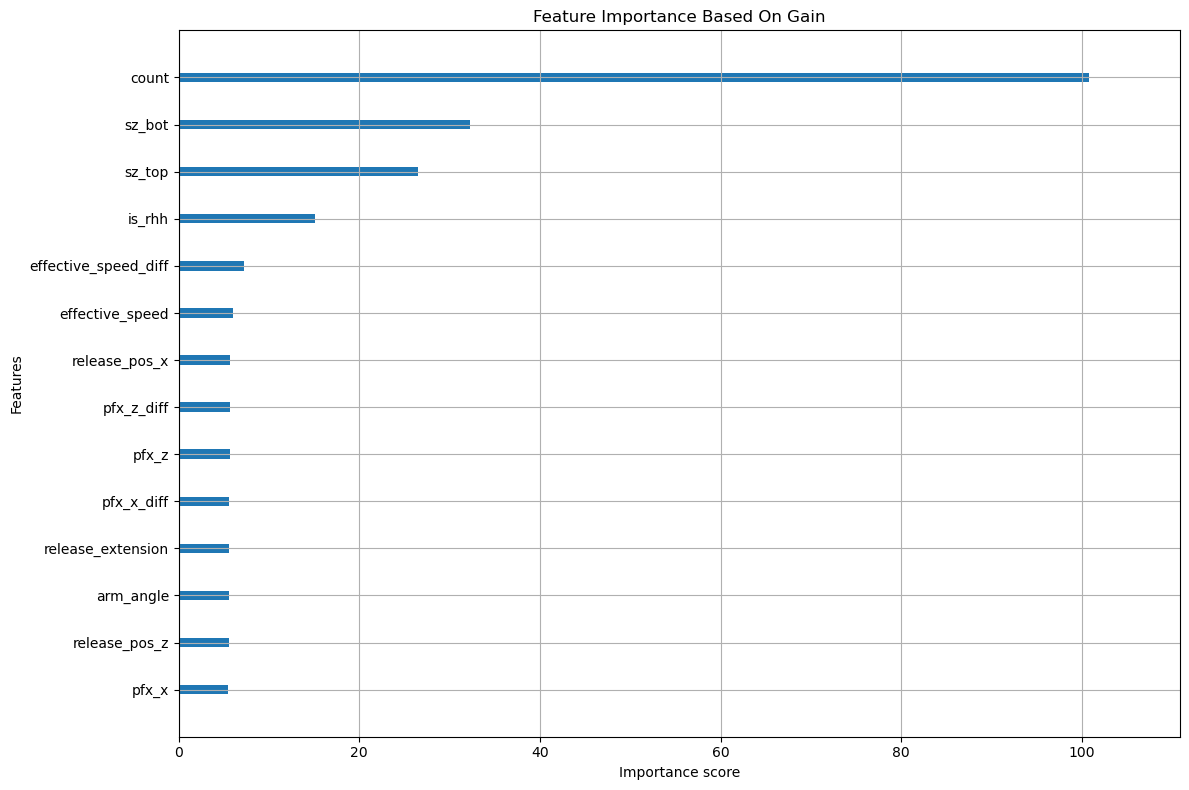

In [45]:
run_mlflow_pipeline(swing_experiment_id, X_train, y_train, X_valid, y_valid, pyfunc_path= pyfunc_model_path)

In [52]:
pyfunc_model_path = "../tmp/p_swing_stuff_diffs_xgb"

pyfunc_model = mlflow.pyfunc.load_model(pyfunc_model_path)

data_predict_swing[["P(No-Swing)", "P(Swing)"]] = pyfunc_model.predict(data_predict_swing_X, params={"predict_method": "predict_proba"})
data_predict_swing["Swing_Pred"] = pyfunc_model.predict(data_predict_swing_X, params={"predict_method": "predict"})

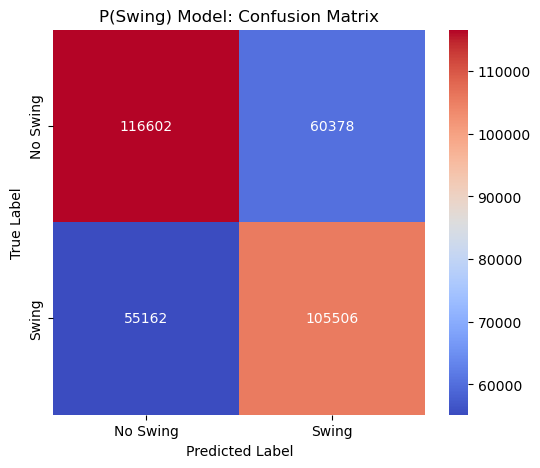

<Figure size 640x480 with 0 Axes>

In [54]:
plot_confusion_mat(
    data_predict_swing["Swing_Event"], data_predict_swing["Swing_Pred"], ["No Swing", "Swing"], ["No Swing", "Swing"],
    plot_title= "P(Swing) Model: Confusion Matrix", save_path= None
)

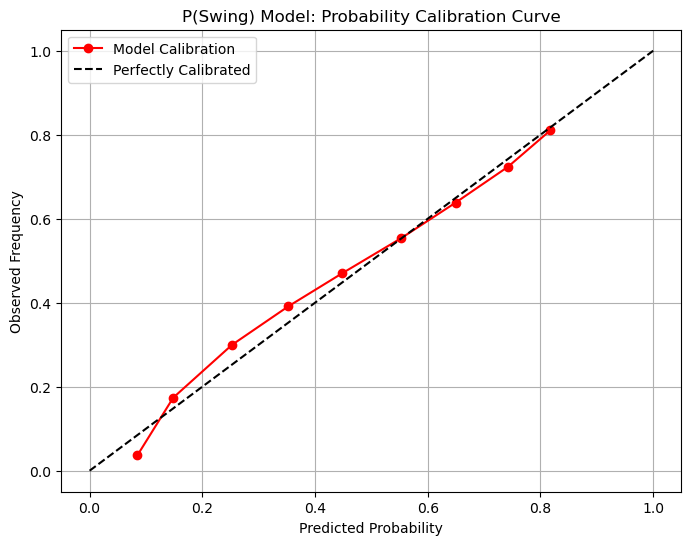

<Figure size 640x480 with 0 Axes>

In [55]:
plot_probability_calibration_curve(
    data_predict_swing["Swing_Event"], data_predict_swing["P(Swing)"], 
    plot_title= "P(Swing) Model: Probability Calibration Curve",
    save_path= None
)

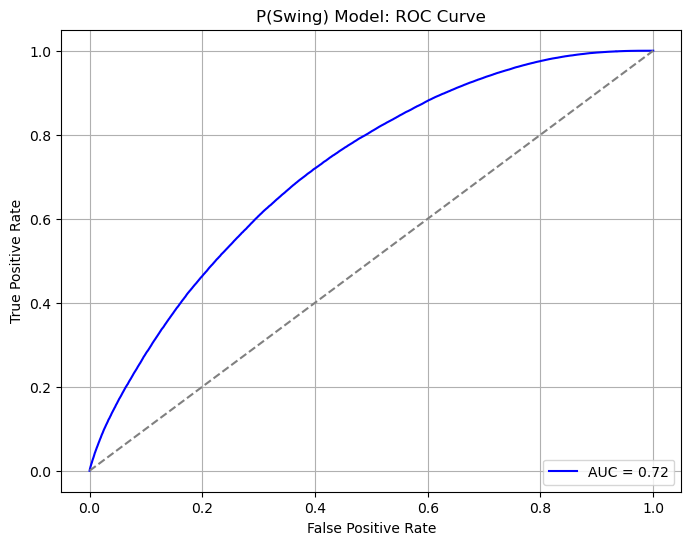

<Figure size 640x480 with 0 Axes>

In [56]:
plot_roc_auc(
    data_predict_swing["Swing_Event"], data_predict_swing["P(Swing)"], plot_title = "P(Swing) Model: ROC Curve",
    save_path= None
)

## P(Take Outcome)

In [12]:
"""
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the P(Take) predictive modeling task under the Stuff+ project. "
    "This experiment contains the models built for modeling outcome probability given a take (P(Swing) < 0.5)."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "p-take-stuff",
    "team": "josh-stuff",
    "project_quarter": "Q2-2025",
    "mlflow.note.content": experiment_description,
}

experiment_name = "P(Take) Models"

# Create the Experiment, providing a unique name
p_take_experiment = client.create_experiment(
    name= experiment_name, tags=experiment_tags
)
"""

In [57]:
# Use search_experiments() to search on the project_name tag key
take_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'p-take-stuff'"
)

take_experiment_id =  vars(take_experiment[0])["_experiment_id"]

In [58]:
client.delete_experiment(take_experiment_id)
client.restore_experiment(take_experiment_id)

experiment = client.get_experiment(take_experiment_id)
experiment

<Experiment: artifact_location='mlflow-artifacts:/409010347608537897', creation_time=1750939806428, experiment_id='409010347608537897', last_update_time=1751121492928, lifecycle_stage='active', name='P(Take) Stuff', tags={'mlflow.note.content': 'This is the P(Take) predictive modeling task under '
                        'the Stuff+ project. This experiment contains the '
                        'models built for modeling outcome probability given a '
                        'take (P(Swing) < 0.5).',
 'project_name': 'p-take-stuff',
 'project_quarter': 'Q2-2025',
 'team': 'josh-stuff'}>

In [62]:
# Get P(Swing) Data
p_take_model_data = get_pitch_outcome_features(data_concat_diff, model_type= "take_stuff", added_features= diff_features)
data_predict_take = get_pitch_outcome_features(data2025_diff, model_type= "take_stuff", added_features= diff_features)

response_col = "Take_Event"
info_cols = ["batter", "pitcher", "game_year", "game_date", response_col]

data_predict_take_X = data_predict_take.drop(info_cols, axis = 1)

pyfunc_model_path = "../tmp/p_take_stuff_diffs_xgb"

p_take_X = p_take_model_data.drop(info_cols, axis = 1)
p_take_y = p_take_model_data[response_col]

X_train, X_valid, y_train, y_valid = train_test_split(p_take_X, p_take_y, train_size= 0.75, stratify = p_take_y)

In [63]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((506083, 14), (506083,), (168695, 14), (168695,))

Name the project/task itself:  P(Take Outcome) with Diffs
Choose problem type (classification/regression):  classification
Choose if Multiclass or Binary (Multiclass/Binary):  Multiclass
Choose model (XGBClassifier, LGBMClassifier, XGB-DMatrix, RandomForestClassifier, LogisticRegression):  XGBClassifier
Give all child run's artifact path:  model
Give the parent run it's own name:  P(Take Outcome) v Diffs
Give the final model artifact's name:  final
Specify the number of trials to run with Optuna:  20


[I 2025-06-28 10:41:25,675] A new study created in memory with name: no-name-64b56b0b-bf69-4a8b-bd38-e32cb8db626f


Creating Optuna study...


[I 2025-06-28 10:41:47,944] Trial 0 finished with value: 0.5932879324884709 and parameters: {'n_estimators': 362, 'eta': 0.2789219524071075, 'gamma': 6.719201747183282e-05, 'max_depth': 7, 'min_child_weight': 10, 'lambda': 0.006663759345497153, 'alpha': 4.752352001754809e-05, 'subsample': 0.4404687089411428, 'colsample_bytree': 0.4143348887895558}. Best is trial 0 with value: 0.5932879324884709.


🏃 View run crawling-kite-58 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/846e7e6f466b446c974afa917774e884
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:43:03,742] Trial 1 finished with value: 0.5938405768692387 and parameters: {'n_estimators': 405, 'eta': 0.017803186331397904, 'gamma': 0.2400552167274296, 'max_depth': 8, 'min_child_weight': 5, 'lambda': 0.19963010558533442, 'alpha': 1.1486566496930086, 'subsample': 0.9382997721130437, 'colsample_bytree': 0.7026008079810568}. Best is trial 0 with value: 0.5932879324884709.


🏃 View run valuable-fox-737 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/3aa572b1a8a34d2892003e3e91f76ec3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:44:30,550] Trial 2 finished with value: 0.5906205726847351 and parameters: {'n_estimators': 1038, 'eta': 0.04318724366300187, 'gamma': 0.1216679671496197, 'max_depth': 10, 'min_child_weight': 1, 'lambda': 0.9274666052241596, 'alpha': 0.0003743049512040654, 'subsample': 0.6018052669109385, 'colsample_bytree': 0.7061056824350292}. Best is trial 2 with value: 0.5906205726847351.


🏃 View run angry-gnat-138 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/99b2be968f554592b92ad6cbb3fe5e79
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:45:05,713] Trial 3 finished with value: 0.6016603242061429 and parameters: {'n_estimators': 337, 'eta': 0.03368691637961599, 'gamma': 0.0005279499435675884, 'max_depth': 2, 'min_child_weight': 6, 'lambda': 0.00016213119422925723, 'alpha': 0.06580358341859274, 'subsample': 0.3539998834931726, 'colsample_bytree': 0.7657265443399182}. Best is trial 2 with value: 0.5906205726847351.


🏃 View run nimble-grouse-316 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/4b7fb375337b4090b15c785576446f0f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:45:36,713] Trial 4 finished with value: 0.5924804159301739 and parameters: {'n_estimators': 263, 'eta': 0.16937367116235796, 'gamma': 1.860258168019561e-05, 'max_depth': 3, 'min_child_weight': 8, 'lambda': 0.006618551433799119, 'alpha': 5.4119962853372345e-05, 'subsample': 0.6451231212806807, 'colsample_bytree': 0.8153802983298601}. Best is trial 2 with value: 0.5906205726847351.


🏃 View run debonair-grub-919 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/c137dfd0534b4ea9ac9409c75adac760
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:47:55,431] Trial 5 finished with value: 0.5902690744527974 and parameters: {'n_estimators': 1231, 'eta': 0.03758827384518626, 'gamma': 0.00015762521194537986, 'max_depth': 7, 'min_child_weight': 2, 'lambda': 0.0007163997147217803, 'alpha': 2.5945035000291714, 'subsample': 0.96478492298171, 'colsample_bytree': 0.4160348001136748}. Best is trial 5 with value: 0.5902690744527974.


🏃 View run wistful-lark-766 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/7f90b50535e34d4fa4c6fe469c32f885
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:48:12,353] Trial 6 finished with value: 0.5978790681210537 and parameters: {'n_estimators': 146, 'eta': 0.15051261347228723, 'gamma': 0.30743344356207136, 'max_depth': 2, 'min_child_weight': 7, 'lambda': 0.10262604410411448, 'alpha': 0.005700347866693844, 'subsample': 0.49434327110125154, 'colsample_bytree': 0.8782686636897101}. Best is trial 5 with value: 0.5902690744527974.


🏃 View run gentle-eel-435 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/ad6c1363d33b4a17838d06c893decac8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:50:55,301] Trial 7 finished with value: 0.5897245989860599 and parameters: {'n_estimators': 1687, 'eta': 0.023661287578430876, 'gamma': 0.0013736398017981028, 'max_depth': 7, 'min_child_weight': 10, 'lambda': 0.014368496050478212, 'alpha': 0.2755659336977028, 'subsample': 0.9071078103315193, 'colsample_bytree': 0.7453406329774892}. Best is trial 7 with value: 0.5897245989860599.


🏃 View run intrigued-jay-706 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/4f144170f1824658901e2f2226c4d34f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:52:45,531] Trial 8 finished with value: 0.5936099722315915 and parameters: {'n_estimators': 1339, 'eta': 0.10737184538445803, 'gamma': 0.5914428546630356, 'max_depth': 2, 'min_child_weight': 6, 'lambda': 0.05930697124357914, 'alpha': 0.6469848997004647, 'subsample': 0.30084372927596387, 'colsample_bytree': 0.5468005959248081}. Best is trial 7 with value: 0.5897245989860599.


🏃 View run lyrical-ram-19 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/5025d8ea0e6e4167a83dc507fabdaf90
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:53:05,588] Trial 9 finished with value: 0.592545602611277 and parameters: {'n_estimators': 733, 'eta': 0.29265028103398283, 'gamma': 0.02176493734534834, 'max_depth': 8, 'min_child_weight': 8, 'lambda': 0.00010345418317425478, 'alpha': 0.002905012393872005, 'subsample': 0.850118554963611, 'colsample_bytree': 0.8529022569313489}. Best is trial 7 with value: 0.5897245989860599.


🏃 View run funny-goat-235 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/15615ee0965f4cff9e6929660ac26f33
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 10:56:37,069] Trial 10 finished with value: 0.5911541084710814 and parameters: {'n_estimators': 1863, 'eta': 0.012993937550258877, 'gamma': 0.0027160369064751625, 'max_depth': 5, 'min_child_weight': 10, 'lambda': 0.0018744679270547382, 'alpha': 0.09041754511895984, 'subsample': 0.7943745263419003, 'colsample_bytree': 0.5751103378486182}. Best is trial 7 with value: 0.5897245989860599.


🏃 View run rare-squid-108 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/31d2deb061a243f8813525b1abe2fadc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:00:01,923] Trial 11 finished with value: 0.5912288849773838 and parameters: {'n_estimators': 1706, 'eta': 0.0258875369842766, 'gamma': 0.0003319627416322194, 'max_depth': 5, 'min_child_weight': 2, 'lambda': 0.0004913513399261309, 'alpha': 7.013561379604195, 'subsample': 0.9944966827705537, 'colsample_bytree': 0.304591616411929}. Best is trial 7 with value: 0.5897245989860599.


🏃 View run incongruous-bear-753 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/03c74c62dd56408bb3d8c1b646a1d445
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:01:29,378] Trial 12 finished with value: 0.5895339756493709 and parameters: {'n_estimators': 1436, 'eta': 0.06826640755852341, 'gamma': 0.005002022196655185, 'max_depth': 6, 'min_child_weight': 3, 'lambda': 0.0007903678335198566, 'alpha': 9.309601285961156, 'subsample': 0.8067396388515319, 'colsample_bytree': 0.99516204785216}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run unruly-sow-89 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/abcdf92d8d544256a8fa0f54429ba924
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:03:07,673] Trial 13 finished with value: 0.590428927453501 and parameters: {'n_estimators': 1659, 'eta': 0.07452986421911344, 'gamma': 0.005913398253763885, 'max_depth': 5, 'min_child_weight': 4, 'lambda': 1.1302270528637424e-05, 'alpha': 0.14871478961755838, 'subsample': 0.7606467984899671, 'colsample_bytree': 0.9895370899226829}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run classy-pug-660 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/00730e9e0f2b4024ba31ceca4b637ce9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:04:23,695] Trial 14 finished with value: 0.5917473021248036 and parameters: {'n_estimators': 1455, 'eta': 0.05760038211785025, 'gamma': 4.427189645725976, 'max_depth': 10, 'min_child_weight': 3, 'lambda': 0.030291052098557408, 'alpha': 0.31261591452441045, 'subsample': 0.8608861904936631, 'colsample_bytree': 0.9695499120089139}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run redolent-vole-371 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/cdcae13e1268452ba5a8da67e5173b10
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:06:37,011] Trial 15 finished with value: 0.5900600542015447 and parameters: {'n_estimators': 1006, 'eta': 0.0213284645951356, 'gamma': 0.002560217373970513, 'max_depth': 6, 'min_child_weight': 0, 'lambda': 0.015929451843028127, 'alpha': 8.984025786455653, 'subsample': 0.7191847509603876, 'colsample_bytree': 0.9192557038255778}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run indecisive-roo-412 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/4e3895e53c1e4635a6f54cf96232eb39
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:09:55,058] Trial 16 finished with value: 0.5923590011102109 and parameters: {'n_estimators': 1946, 'eta': 0.012536316456461043, 'gamma': 0.025313952986772182, 'max_depth': 4, 'min_child_weight': 4, 'lambda': 0.00180746068231994, 'alpha': 0.016008983247179503, 'subsample': 0.8797241696907776, 'colsample_bytree': 0.5913328329542289}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run tasteful-goat-452 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/be0781d28812415e8bb16005b71a1573
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:10:52,954] Trial 17 finished with value: 0.589904756967863 and parameters: {'n_estimators': 1519, 'eta': 0.07368133165560571, 'gamma': 0.0011718068311306754, 'max_depth': 8, 'min_child_weight': 8, 'lambda': 3.3732345933006675e-05, 'alpha': 1.584703059159789, 'subsample': 0.7147287295945216, 'colsample_bytree': 0.7771693138263053}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run spiffy-robin-593 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/1e4656251e574890b77f8dff99f1a6f2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:12:23,098] Trial 18 finished with value: 0.5904046907008751 and parameters: {'n_estimators': 1262, 'eta': 0.05694966725059659, 'gamma': 0.030641070222313063, 'max_depth': 6, 'min_child_weight': 4, 'lambda': 0.00035145825042294033, 'alpha': 0.025336486310164896, 'subsample': 0.586126300695106, 'colsample_bytree': 0.6593593626820563}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run whimsical-toad-814 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/35fd8fb6277b4d5caa60736338774d42
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


[I 2025-06-28 11:14:34,272] Trial 19 finished with value: 0.5903902697562369 and parameters: {'n_estimators': 721, 'eta': 0.03013636536391686, 'gamma': 2.9307453321817478e-05, 'max_depth': 9, 'min_child_weight': 0, 'lambda': 0.004612454771830819, 'alpha': 0.0010812708217984826, 'subsample': 0.8008702003788125, 'colsample_bytree': 0.9345016823967351}. Best is trial 12 with value: 0.5895339756493709.


🏃 View run suave-robin-668 at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/6eb3cb660f474438843001bc4c50bea0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897
Logging best parameters and training final model...
Creating feature importance plot...
Feature importance plot saved as ../model_feature_importances.png


2025/06/28 11:17:48 INFO mlflow.pyfunc: Validating input example against model signature


🏃 View run P(Take Outcome) v Diffs at: http://127.0.0.1:8080/#/experiments/409010347608537897/runs/92e10489161e49babdd0281ef419c468
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/409010347608537897


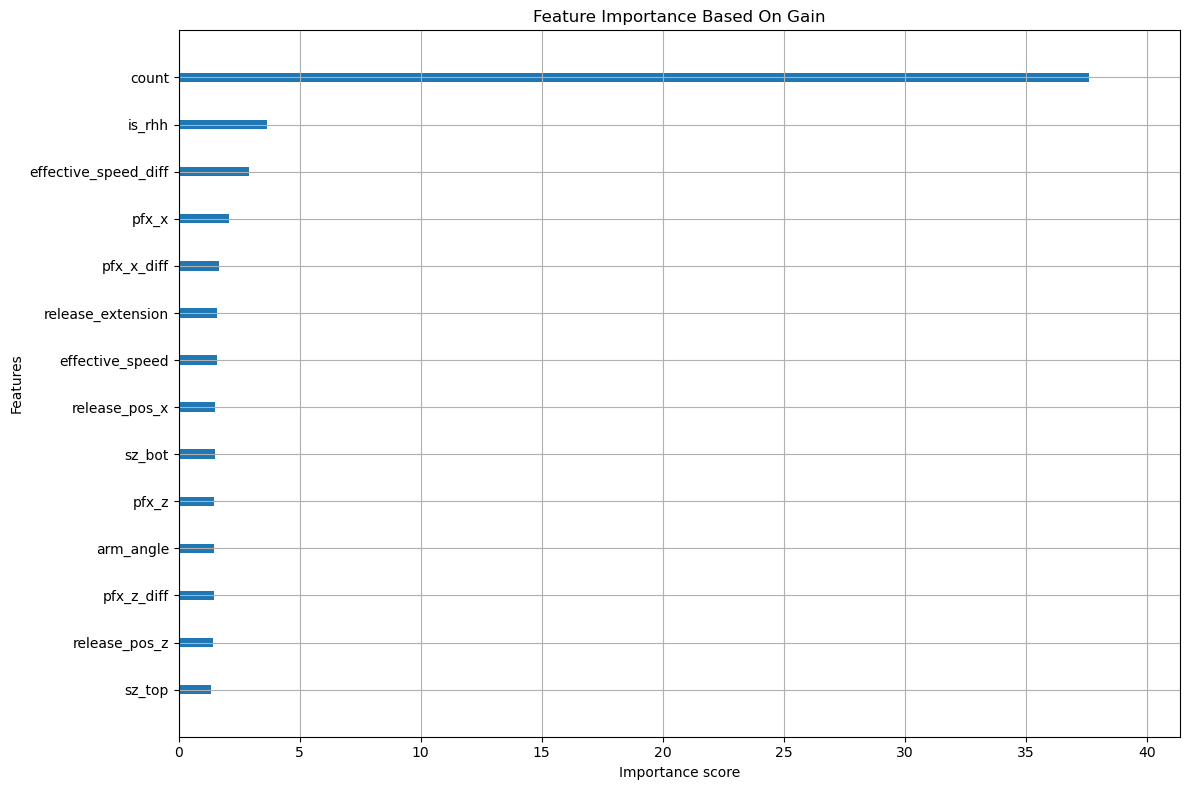

In [64]:
run_mlflow_pipeline(take_experiment_id, X_train, y_train, X_valid, y_valid, pyfunc_path= pyfunc_model_path)

In [65]:
pyfunc_model_path = "../tmp/p_take_stuff_diffs_xgb"

pyfunc_model = mlflow.pyfunc.load_model(pyfunc_model_path)

data_predict_take[["P(Ball)", "P(Called_Strike)", "P(HBP)"]] = pyfunc_model.predict(data_predict_take_X, params={"predict_method": "predict_proba"})
data_predict_take["Take_Pred"] = pyfunc_model.predict(data_predict_take_X, params={"predict_method": "predict"})

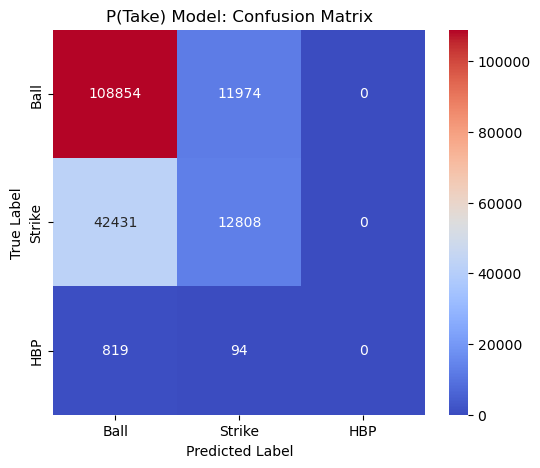

<Figure size 640x480 with 0 Axes>

In [66]:
plot_confusion_mat(
    data_predict_take["Take_Event"], data_predict_take["Take_Pred"], ["Ball", "Strike", "HBP"], ["Ball", "Strike", "HBP"],
    plot_title= "P(Take) Model: Confusion Matrix", save_path= None
)

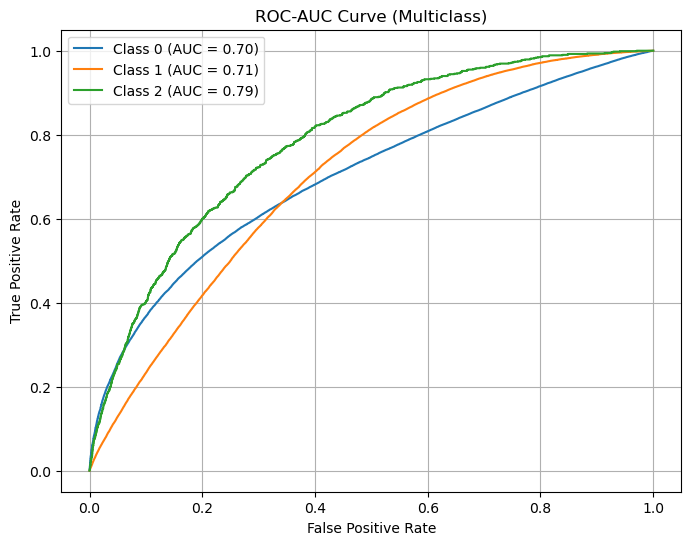

<Figure size 640x480 with 0 Axes>

In [67]:
plot_roc_auc_multiclass(
    data_predict_take["Take_Event"], data_predict_take[["P(Ball)", "P(Called_Strike)", "P(HBP)"]].values, 3,
    save_path= None
)

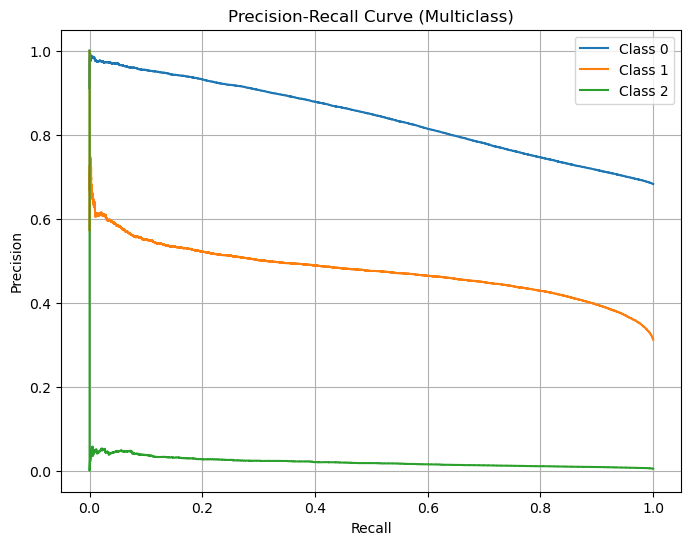

<Figure size 640x480 with 0 Axes>

In [68]:
plot_precision_recall(
    data_predict_take["Take_Event"], data_predict_take[["P(Ball)", "P(Called_Strike)", "P(HBP)"]].values, 3,
    save_path= None
)

## P(Contact)

In [35]:
"""
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the P(Contact) predictive modeling task under the Stuff+ project. "
    "This experiment contains the models built for modeling contact probability given swing (P(Swing) >= 0.5)."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "p-contact-stuff",
    "team": "josh-stuff",
    "project_quarter": "Q2-2025",
    "mlflow.note.content": experiment_description,
}

experiment_name = "P(Contact)"

# Create the Experiment, providing a unique name
p_contact_experiment = client.create_experiment(
    name= experiment_name, tags=experiment_tags
)
"""

''

In [69]:
# Use search_experiments() to search on the project_name tag key
contact_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'p-contact-stuff'"
)

contact_experiment_id =  vars(contact_experiment[0])["_experiment_id"]

In [70]:
client.delete_experiment(contact_experiment_id)
client.restore_experiment(contact_experiment_id)

experiment = client.get_experiment(contact_experiment_id)
experiment

<Experiment: artifact_location='mlflow-artifacts:/172833310238846461', creation_time=1751076367169, experiment_id='172833310238846461', last_update_time=1751124023345, lifecycle_stage='active', name='P(Contact) Stuff', tags={'mlflow.note.content': 'This is the P(Contact) predictive modeling task under '
                        'the Stuff+ project. This experiment contains the '
                        'models built for modeling contact probability given '
                        'swing (P(Swing) >= 0.5).',
 'project_name': 'p-contact-stuff',
 'project_quarter': 'Q2-2025',
 'team': 'josh-stuff'}>

In [71]:
# Get P(Contact) Data
p_con_model_data = get_pitch_outcome_features(data_concat_diff, model_type= "contact_stuff", added_features= diff_features)
data_predict_contact = get_pitch_outcome_features(data2025_diff, model_type= "contact_stuff", added_features= diff_features)

pyfunc_model_path = "../tmp/p_contact_stuff_diffs_xgb"

response_col = "Contact_Event"
info_cols = ["batter", "pitcher", "game_year", "game_date", response_col]

# Refine into train, validation data
data_predict_contact_X = data_predict_contact.drop(info_cols, axis = 1)

p_contact_X = p_con_model_data.drop(info_cols, axis = 1)
p_contact_y = p_con_model_data[response_col]

X_train, X_valid, y_train, y_valid = train_test_split(p_contact_X, p_contact_y, train_size= 0.75, stratify = p_contact_y)

In [73]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((464247, 14), (464247,), (154749, 14), (154749,))

Name the project/task itself:  P(Contact) with Diffs
Choose problem type (classification/regression):  classification
Choose if Multiclass or Binary (Multiclass/Binary):  Binary
Choose if Probability Calibration is needed or not (Yes/No):  Yes
Choose Probability Calibration Method (Sigmoid/Isotonic):  Isotonic
Choose model (XGBClassifier, LGBMClassifier, XGB-DMatrix, RandomForestClassifier, LogisticRegression):  XGBClassifier
Give all child run's artifact path:  model
Give the parent run it's own name:  P(Contact) with Diffs
Give the final model artifact's name:  final
Specify the number of trials to run with Optuna:  20


[I 2025-06-28 11:28:43,568] A new study created in memory with name: no-name-f97a8622-64d5-4e26-9990-1c70e3c4ab49


Creating Optuna study...


[I 2025-06-28 11:28:57,440] Trial 0 finished with value: 0.5452475726480656 and parameters: {'n_estimators': 678, 'eta': 0.12158605808913213, 'gamma': 0.2975875516603045, 'max_depth': 7, 'min_child_weight': 8, 'lambda': 0.0036988691241081335, 'alpha': 0.000868137024615936, 'subsample': 0.8707587253581728, 'colsample_bytree': 0.6028212103986765}. Best is trial 0 with value: 0.5452475726480656.


🏃 View run enthused-fly-106 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/487dfe4cf46949aeb9a0495ccd3ad6b0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:29:37,751] Trial 1 finished with value: 0.5444542903815127 and parameters: {'n_estimators': 738, 'eta': 0.024387159165105296, 'gamma': 0.0006915825448973746, 'max_depth': 10, 'min_child_weight': 0, 'lambda': 0.003195494882112607, 'alpha': 0.0004297366057236692, 'subsample': 0.9616544066767085, 'colsample_bytree': 0.5068328037404414}. Best is trial 1 with value: 0.5444542903815127.


🏃 View run languid-yak-413 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/2c5a632bbe49451982b2dca23b091260
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:30:14,027] Trial 2 finished with value: 0.5472583369789713 and parameters: {'n_estimators': 1167, 'eta': 0.016802618768096477, 'gamma': 0.0002784442807748395, 'max_depth': 4, 'min_child_weight': 10, 'lambda': 0.1619862232892954, 'alpha': 0.00016746579194046218, 'subsample': 0.8753837624558276, 'colsample_bytree': 0.918207738366202}. Best is trial 1 with value: 0.5444542903815127.


🏃 View run agreeable-steed-367 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/84fac75dcda8465b956e2c239653bc90
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:30:28,497] Trial 3 finished with value: 0.5458248218665801 and parameters: {'n_estimators': 417, 'eta': 0.08252589045075436, 'gamma': 0.035341024840721276, 'max_depth': 10, 'min_child_weight': 7, 'lambda': 0.08405624897121665, 'alpha': 9.467838670576134e-05, 'subsample': 0.6443123083718276, 'colsample_bytree': 0.4438772042879179}. Best is trial 1 with value: 0.5444542903815127.


🏃 View run lyrical-tern-623 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/1d55439debf548f29a846de8c766d91d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:30:49,434] Trial 4 finished with value: 0.5480859485306872 and parameters: {'n_estimators': 695, 'eta': 0.19842393347457674, 'gamma': 3.4923672463902824e-05, 'max_depth': 2, 'min_child_weight': 9, 'lambda': 0.9050027009273657, 'alpha': 0.00047706063772392257, 'subsample': 0.9121389060095737, 'colsample_bytree': 0.5687343455766944}. Best is trial 1 with value: 0.5444542903815127.


🏃 View run kindly-finch-575 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/b43ccf50b6c840ae9498879d1c74e6ab
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:31:30,163] Trial 5 finished with value: 0.5446013466442433 and parameters: {'n_estimators': 1674, 'eta': 0.052346327575344076, 'gamma': 0.4552996512452048, 'max_depth': 5, 'min_child_weight': 10, 'lambda': 0.354665162889548, 'alpha': 1.8752852650936362, 'subsample': 0.8199074345993238, 'colsample_bytree': 0.5378391048530382}. Best is trial 1 with value: 0.5444542903815127.


🏃 View run skillful-boar-824 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/ec6216a8f08c4fbbb0678e0cca410f01
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:31:52,230] Trial 6 finished with value: 0.5450321762451925 and parameters: {'n_estimators': 539, 'eta': 0.06798602466080063, 'gamma': 0.0003069741505618399, 'max_depth': 5, 'min_child_weight': 0, 'lambda': 0.004062217132300175, 'alpha': 0.2954900297730648, 'subsample': 0.5789991312928624, 'colsample_bytree': 0.885991821908765}. Best is trial 1 with value: 0.5444542903815127.


🏃 View run orderly-gnat-916 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/dc0eaedb5a4c41fda0bc683adfa1b56c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:32:38,883] Trial 7 finished with value: 0.5444016480551966 and parameters: {'n_estimators': 867, 'eta': 0.021949878486033775, 'gamma': 0.18921029473047266, 'max_depth': 8, 'min_child_weight': 3, 'lambda': 0.12130766421668081, 'alpha': 0.7990913038837348, 'subsample': 0.8438660000280873, 'colsample_bytree': 0.39177123880259807}. Best is trial 7 with value: 0.5444016480551966.


🏃 View run upbeat-shrike-845 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/26bc25e2d0d449dda91597eb63195dc3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:33:10,015] Trial 8 finished with value: 0.5468102685173656 and parameters: {'n_estimators': 899, 'eta': 0.026419967102670316, 'gamma': 0.0011577290219886057, 'max_depth': 4, 'min_child_weight': 2, 'lambda': 0.00029653515039171287, 'alpha': 0.4814122287769896, 'subsample': 0.35483077192548496, 'colsample_bytree': 0.6226380996883901}. Best is trial 7 with value: 0.5444016480551966.


🏃 View run sassy-shrike-127 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/725932b9872c4dee878beea330df3c21
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:33:26,375] Trial 9 finished with value: 0.5449932900823463 and parameters: {'n_estimators': 611, 'eta': 0.05798083327359225, 'gamma': 0.2606480934329986, 'max_depth': 9, 'min_child_weight': 1, 'lambda': 0.09996208208643627, 'alpha': 0.00717538678596992, 'subsample': 0.8824896385191456, 'colsample_bytree': 0.7726897222388871}. Best is trial 7 with value: 0.5444016480551966.


🏃 View run melodic-horse-786 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/68e47d1ed0874179afeb517d20f1ad03
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:34:25,859] Trial 10 finished with value: 0.5460311510486936 and parameters: {'n_estimators': 1295, 'eta': 0.010167633267417733, 'gamma': 2.5836020245922997, 'max_depth': 8, 'min_child_weight': 4, 'lambda': 1.651932611244471e-05, 'alpha': 8.53038089934901, 'subsample': 0.7341338088054438, 'colsample_bytree': 0.32502572547726694}. Best is trial 7 with value: 0.5444016480551966.


🏃 View run respected-stork-865 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/00ae3af7dadc47ee9f3162c0df2b6c2e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:34:43,208] Trial 11 finished with value: 0.547377215556378 and parameters: {'n_estimators': 185, 'eta': 0.027528404284810015, 'gamma': 0.009299478005327657, 'max_depth': 10, 'min_child_weight': 3, 'lambda': 0.01105276017376848, 'alpha': 1.1128833414031396e-05, 'subsample': 0.9830791652057926, 'colsample_bytree': 0.33146385830444025}. Best is trial 7 with value: 0.5444016480551966.


🏃 View run upset-sloth-447 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/3c9679c5b49f48b5955a34a15a74dace
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:35:29,055] Trial 12 finished with value: 0.5443730426230069 and parameters: {'n_estimators': 1458, 'eta': 0.02946987225559803, 'gamma': 1.1120043046662367e-05, 'max_depth': 8, 'min_child_weight': 6, 'lambda': 0.0003985807722929733, 'alpha': 0.03464526422053848, 'subsample': 0.9943353330523105, 'colsample_bytree': 0.4444362182994289}. Best is trial 12 with value: 0.5443730426230069.


🏃 View run kindly-shad-530 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/f2d0b47e900842d6a4fead09cf031c25
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:36:00,236] Trial 13 finished with value: 0.5448484397043428 and parameters: {'n_estimators': 1519, 'eta': 0.038335025940712426, 'gamma': 0.026939854014751415, 'max_depth': 7, 'min_child_weight': 6, 'lambda': 0.00034506900601483326, 'alpha': 0.03757621914378959, 'subsample': 0.5284462419715125, 'colsample_bytree': 0.43731006142430534}. Best is trial 12 with value: 0.5443730426230069.


🏃 View run loud-elk-599 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/c8a530876f564ab3847c32b460a821f9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:37:20,703] Trial 14 finished with value: 0.5437596883503111 and parameters: {'n_estimators': 1986, 'eta': 0.013404028156884606, 'gamma': 1.6564730430398792e-05, 'max_depth': 8, 'min_child_weight': 5, 'lambda': 0.00018935720538619074, 'alpha': 0.036808395376125305, 'subsample': 0.7565867764869765, 'colsample_bytree': 0.7217648358624091}. Best is trial 14 with value: 0.5437596883503111.


🏃 View run smiling-penguin-521 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/292c0258f1084935ac3454064dc5af49
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:38:21,868] Trial 15 finished with value: 0.5437970774680413 and parameters: {'n_estimators': 1881, 'eta': 0.012114298713567655, 'gamma': 1.252859466882099e-05, 'max_depth': 8, 'min_child_weight': 5, 'lambda': 0.00017740164333877545, 'alpha': 0.031033081213724403, 'subsample': 0.73948882193434, 'colsample_bytree': 0.7409896955699751}. Best is trial 14 with value: 0.5437596883503111.


🏃 View run clean-cod-817 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/4f70c4c3c21e4b4e880451b812175a2d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:39:32,816] Trial 16 finished with value: 0.5445875892899074 and parameters: {'n_estimators': 1982, 'eta': 0.01109583525531772, 'gamma': 4.7918334329713895e-05, 'max_depth': 6, 'min_child_weight': 5, 'lambda': 3.319302673682905e-05, 'alpha': 0.0046856312191876255, 'subsample': 0.7439094966328742, 'colsample_bytree': 0.7664817048345625}. Best is trial 14 with value: 0.5437596883503111.


🏃 View run brawny-jay-298 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/5298d8845cd44079b20fb0de42484956
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:40:49,076] Trial 17 finished with value: 0.5439374793083479 and parameters: {'n_estimators': 1934, 'eta': 0.015943846533722918, 'gamma': 1.023151130492752e-05, 'max_depth': 7, 'min_child_weight': 5, 'lambda': 6.652113418527991e-05, 'alpha': 0.08049452843520102, 'subsample': 0.7380207218892654, 'colsample_bytree': 0.7478248075959756}. Best is trial 14 with value: 0.5437596883503111.


🏃 View run worried-flea-91 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/13827408d7ff41f286522b24789bf8dd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:41:40,201] Trial 18 finished with value: 0.5437574088675295 and parameters: {'n_estimators': 1736, 'eta': 0.014682334706742616, 'gamma': 4.2048684159094755e-05, 'max_depth': 9, 'min_child_weight': 7, 'lambda': 0.00011960196567602509, 'alpha': 0.0023518671134678624, 'subsample': 0.4573296177983701, 'colsample_bytree': 0.7195135108074706}. Best is trial 18 with value: 0.5437574088675295.


🏃 View run placid-hawk-160 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/0028397a5d864fc8bff688abb730ff1c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


[I 2025-06-28 11:42:36,703] Trial 19 finished with value: 0.5440823881118754 and parameters: {'n_estimators': 1670, 'eta': 0.015185781459885885, 'gamma': 0.00011123749077397546, 'max_depth': 9, 'min_child_weight': 7, 'lambda': 0.0009569194627951341, 'alpha': 0.0021594708554653, 'subsample': 0.4271130405881987, 'colsample_bytree': 0.6770812088545878}. Best is trial 18 with value: 0.5437574088675295.


🏃 View run bedecked-smelt-836 at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/0ba2eea9a1394d92ad55aef5259bfa2c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461
Logging best parameters and training final model...
Training additional model to calibrate predicted probabilities...
Creating feature importance plot...
Feature importance plot saved as ../model_feature_importances.png


2025/06/28 11:48:11 INFO mlflow.pyfunc: Validating input example against model signature


🏃 View run P(Contact) with Diffs at: http://127.0.0.1:8080/#/experiments/172833310238846461/runs/86557e606a8d4e67b7a460bb2a18abf6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/172833310238846461


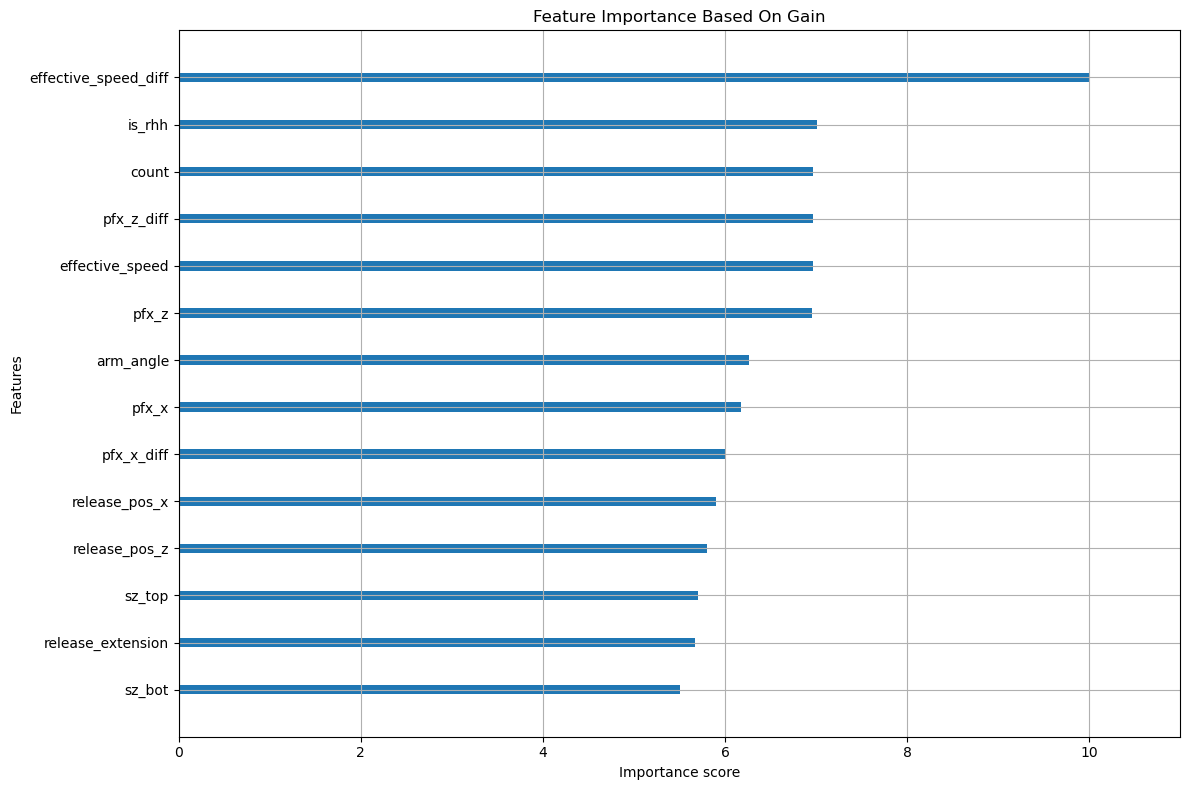

In [74]:
run_mlflow_pipeline(contact_experiment_id, X_train, y_train, X_valid, y_valid, pyfunc_path= pyfunc_model_path)

In [75]:
# Reference: https://mlflow.org/docs/latest/traditional-ml/creating-custom-pyfunc/notebooks/override-predict
pyfunc_model_path = "../tmp/p_contact_stuff_diffs_xgb"

# The model is logged with an input example
pyfunc_model = mlflow.pyfunc.load_model(pyfunc_model_path)

data_predict_contact[["P(No-Contact)", "P(Contact)"]] = pyfunc_model.predict(data_predict_contact_X, 
                                                                             params={"predict_method": "predict_proba"})
data_predict_contact["Contact_Pred"] = pyfunc_model.predict(data_predict_contact_X, params={"predict_method": "predict"})

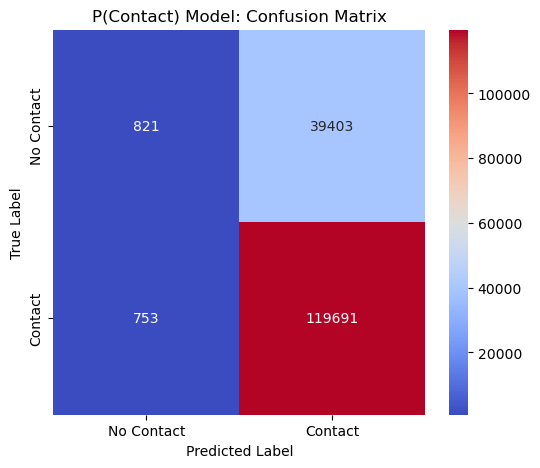

<Figure size 640x480 with 0 Axes>

In [76]:
plot_confusion_mat(
    data_predict_contact["Contact_Event"], data_predict_contact["Contact_Pred"], ["No Contact", "Contact"], ["No Contact", "Contact"],
    plot_title= "P(Contact) Model: Confusion Matrix", save_path= None
)

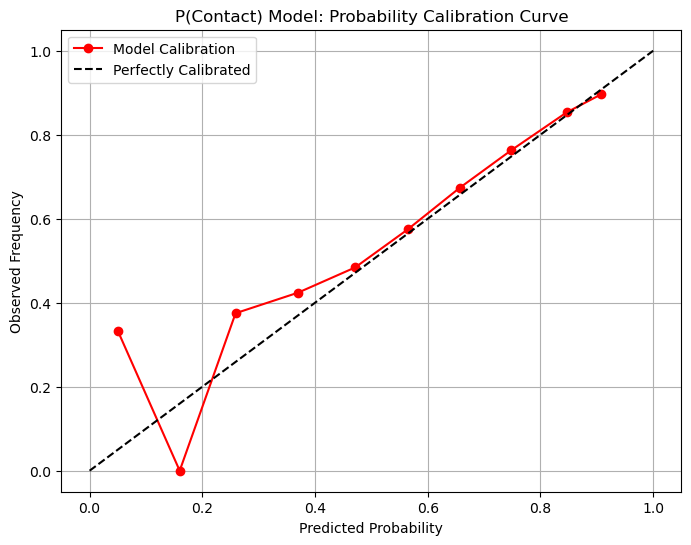

<Figure size 640x480 with 0 Axes>

In [77]:
plot_probability_calibration_curve(
    data_predict_contact["Contact_Event"], data_predict_contact["P(Contact)"], 
    plot_title= "P(Contact) Model: Probability Calibration Curve",
    save_path=None
)

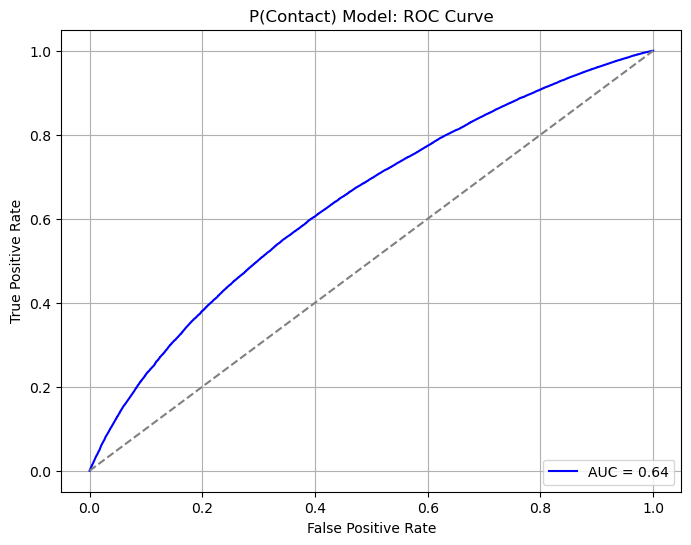

<Figure size 640x480 with 0 Axes>

In [78]:
plot_roc_auc(
    data_predict_contact["Contact_Event"], data_predict_contact["P(Contact)"], plot_title = "P(Contact) Model: ROC Curve",
    save_path= None
)

## P(Fair)

In [47]:
"""
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the P(Fair) predictive modeling task under the Stuff+ project. "
    "This experiment contains the models built for modeling fair ball probability given contact (P(Contact) >= 0.5)."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "p-fair-stuff",
    "team": "josh-stuff",
    "project_quarter": "Q2-2025",
    "mlflow.note.content": experiment_description,
}

experiment_name = "P(Fair) Stuff"

# Create the Experiment, providing a unique name
p_fair_experiment = client.create_experiment(
    name= experiment_name, tags=experiment_tags
)
"""
print("")

In [79]:
# Use search_experiments() to search on the project_name tag key
fair_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'p-fair-stuff'"
)

fair_experiment_id =  vars(fair_experiment[0])["_experiment_id"]

client.delete_experiment(fair_experiment_id)
client.restore_experiment(fair_experiment_id)

experiment = client.get_experiment(fair_experiment_id)
experiment

<Experiment: artifact_location='mlflow-artifacts:/960223118143944571', creation_time=1751078008791, experiment_id='960223118143944571', last_update_time=1751126730729, lifecycle_stage='active', name='P(Fair) Stuff', tags={'mlflow.note.content': 'This is the P(Fair) predictive modeling task under '
                        'the Stuff+ project. This experiment contains the '
                        'models built for modeling fair ball probability given '
                        'contact (P(Contact) >= 0.5).',
 'project_name': 'p-fair-stuff',
 'project_quarter': 'Q2-2025',
 'team': 'josh-stuff'}>

In [80]:
# Get P(Fair) Data
p_fair_model_data = get_pitch_outcome_features(data_concat_diff, model_type= "fair_stuff", added_features= diff_features)
data_predict_fair = get_pitch_outcome_features(data2025_diff, model_type= "fair_stuff", added_features= diff_features)

pyfunc_model_path = "../tmp/p_fair_stuff_diffs_xgb"

response_col = "Fair_Event"
info_cols = ["batter", "pitcher", "game_year", "game_date", response_col]

# Refine into train, validation data
data_predict_fair_X = data_predict_fair.drop(info_cols, axis = 1)

p_fair_X = p_fair_model_data.drop(info_cols, axis = 1)
p_fair_y = p_fair_model_data[response_col]

X_train, X_valid, y_train, y_valid = train_test_split(p_fair_X, p_fair_y, train_size= 0.75, stratify = p_fair_y)

In [81]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((345405, 14), (345405,), (115135, 14), (115135,))

Name the project/task itself:  P(Fair) with Diffs
Choose problem type (classification/regression):  classification
Choose if Multiclass or Binary (Multiclass/Binary):  Binary
Choose if Probability Calibration is needed or not (Yes/No):  Yes
Choose Probability Calibration Method (Sigmoid/Isotonic):  Isotonic
Choose model (XGBClassifier, LGBMClassifier, XGB-DMatrix, RandomForestClassifier, LogisticRegression):  XGBClassifier
Give all child run's artifact path:  model
Give the parent run it's own name:  P(Fair) vDiffs
Give the final model artifact's name:  final
Specify the number of trials to run with Optuna:  20


[I 2025-06-28 12:06:59,984] A new study created in memory with name: no-name-6c7fb9e7-b757-4c62-8745-d684c7121108


Creating Optuna study...


[I 2025-06-28 12:07:10,653] Trial 0 finished with value: 0.6830255376974803 and parameters: {'n_estimators': 1527, 'eta': 0.11111198576591004, 'gamma': 0.0034777063068002385, 'max_depth': 8, 'min_child_weight': 2, 'lambda': 0.2138757019318543, 'alpha': 0.00046837119344621893, 'subsample': 0.925971303556332, 'colsample_bytree': 0.8066204134343862}. Best is trial 0 with value: 0.6830255376974803.


🏃 View run gentle-hawk-160 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/827903862e9242679ef3a31ff7beb0ea
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:07:21,791] Trial 1 finished with value: 0.6828358437004468 and parameters: {'n_estimators': 315, 'eta': 0.09296144123944602, 'gamma': 3.2596461154136187, 'max_depth': 4, 'min_child_weight': 10, 'lambda': 0.4951837938287757, 'alpha': 2.4791009059962264e-05, 'subsample': 0.6217835884829921, 'colsample_bytree': 0.988090021574398}. Best is trial 1 with value: 0.6828358437004468.


🏃 View run melodic-chimp-836 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/c0ea3dd760c34c9185df06218355aa49
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:07:32,504] Trial 2 finished with value: 0.6845861747289443 and parameters: {'n_estimators': 360, 'eta': 0.056907943892008025, 'gamma': 0.00025095293692057674, 'max_depth': 2, 'min_child_weight': 4, 'lambda': 0.3797517906808185, 'alpha': 9.235747799050559, 'subsample': 0.8900416959890196, 'colsample_bytree': 0.7840968410870355}. Best is trial 1 with value: 0.6828358437004468.


🏃 View run intelligent-elk-212 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/8b8cd6466e9b4bcfaace22378721e525
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:07:46,878] Trial 3 finished with value: 0.6831538754507089 and parameters: {'n_estimators': 1677, 'eta': 0.10084627813392229, 'gamma': 1.9679485604385574, 'max_depth': 5, 'min_child_weight': 8, 'lambda': 0.00015922788424216244, 'alpha': 5.739445956401719, 'subsample': 0.42043673687551775, 'colsample_bytree': 0.3521270989360803}. Best is trial 1 with value: 0.6828358437004468.


🏃 View run stately-kit-770 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/557c379e2ca1466fbd72821698c99c97
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:08:12,192] Trial 4 finished with value: 0.6824544607302055 and parameters: {'n_estimators': 1089, 'eta': 0.012864473112203309, 'gamma': 0.007801353636391363, 'max_depth': 10, 'min_child_weight': 2, 'lambda': 0.6101500171865301, 'alpha': 0.00010213948383815901, 'subsample': 0.4576203774123676, 'colsample_bytree': 0.6986334391975579}. Best is trial 4 with value: 0.6824544607302055.


🏃 View run popular-yak-201 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/79d358c1a97b4d26a8a304190d908eaf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:08:32,483] Trial 5 finished with value: 0.6827979915084108 and parameters: {'n_estimators': 469, 'eta': 0.013926720504598918, 'gamma': 3.7461876374551006e-05, 'max_depth': 6, 'min_child_weight': 3, 'lambda': 0.0032949713381844143, 'alpha': 0.00011311455377798709, 'subsample': 0.6504035646655231, 'colsample_bytree': 0.5383801493580177}. Best is trial 4 with value: 0.6824544607302055.


🏃 View run adaptable-horse-555 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/e01d4d028b0340759229a1463a8ba8bf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:09:07,578] Trial 6 finished with value: 0.6843854816968937 and parameters: {'n_estimators': 1368, 'eta': 0.017230743572554916, 'gamma': 0.012605900200779667, 'max_depth': 2, 'min_child_weight': 2, 'lambda': 0.12373940052486453, 'alpha': 0.021487046927244843, 'subsample': 0.46491220141235545, 'colsample_bytree': 0.8572528272130091}. Best is trial 4 with value: 0.6824544607302055.


🏃 View run exultant-donkey-610 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/6f1394a9293c440c80bfd2482c30bc02
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:09:40,262] Trial 7 finished with value: 0.6844721286049327 and parameters: {'n_estimators': 1289, 'eta': 0.020112869683622022, 'gamma': 1.8263847058139304, 'max_depth': 2, 'min_child_weight': 3, 'lambda': 0.06506514280348537, 'alpha': 1.1196700560690946e-05, 'subsample': 0.6626778956324761, 'colsample_bytree': 0.5558365753091976}. Best is trial 4 with value: 0.6824544607302055.


🏃 View run amusing-cod-573 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/61496eb8da6c45f488b9bf701f89817e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:10:24,785] Trial 8 finished with value: 0.6827771313051078 and parameters: {'n_estimators': 1541, 'eta': 0.012018054735490807, 'gamma': 0.0003808857467652977, 'max_depth': 4, 'min_child_weight': 7, 'lambda': 0.0009878620155307771, 'alpha': 0.006124040651581219, 'subsample': 0.6095254591464776, 'colsample_bytree': 0.9911633433513531}. Best is trial 4 with value: 0.6824544607302055.


🏃 View run smiling-crane-844 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/38758df5d4b740b4b95c707b81035a4f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:10:38,375] Trial 9 finished with value: 0.6831453610528812 and parameters: {'n_estimators': 244, 'eta': 0.058313173324052225, 'gamma': 0.00015556092906187762, 'max_depth': 4, 'min_child_weight': 1, 'lambda': 0.0002541912077900524, 'alpha': 0.2005506072775182, 'subsample': 0.9192205607660542, 'colsample_bytree': 0.7608177355100947}. Best is trial 4 with value: 0.6824544607302055.


🏃 View run indecisive-cat-668 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/18a24630d5084176a9a62a236bc8af04
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:10:49,109] Trial 10 finished with value: 0.6890973280544579 and parameters: {'n_estimators': 841, 'eta': 0.22369618719722206, 'gamma': 0.05710327927994503, 'max_depth': 10, 'min_child_weight': 0, 'lambda': 1.104790052198072e-05, 'alpha': 0.001409401182665768, 'subsample': 0.3007029869889496, 'colsample_bytree': 0.6310672866343868}. Best is trial 4 with value: 0.6824544607302055.


🏃 View run abrasive-sponge-246 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/a6e164ac183a419cb63b3444e42b7e00
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:11:14,448] Trial 11 finished with value: 0.6823448284450198 and parameters: {'n_estimators': 1991, 'eta': 0.010275765738095556, 'gamma': 0.0017476489321707172, 'max_depth': 10, 'min_child_weight': 6, 'lambda': 0.006476634503349435, 'alpha': 0.008381942853705329, 'subsample': 0.5161630736293784, 'colsample_bytree': 0.9625949758893984}. Best is trial 11 with value: 0.6823448284450198.


🏃 View run merciful-crane-505 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/0d4a383c99824807a0420bb95a1b0466
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:11:32,033] Trial 12 finished with value: 0.6838794277832928 and parameters: {'n_estimators': 1994, 'eta': 0.02933451215116423, 'gamma': 0.0032682455282633453, 'max_depth': 10, 'min_child_weight': 6, 'lambda': 0.012083303648807919, 'alpha': 0.1496814732840328, 'subsample': 0.4781714433146622, 'colsample_bytree': 0.39770397692769316}. Best is trial 11 with value: 0.6823448284450198.


🏃 View run defiant-foal-778 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/4ad9f8f5da0a426ab2509446745de7e1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:11:45,125] Trial 13 finished with value: 0.6824493879023966 and parameters: {'n_estimators': 919, 'eta': 0.0272205484878029, 'gamma': 0.12826195578626476, 'max_depth': 8, 'min_child_weight': 5, 'lambda': 0.015562193909969674, 'alpha': 0.0003823226123859372, 'subsample': 0.36222556761115116, 'colsample_bytree': 0.907781748848648}. Best is trial 11 with value: 0.6823448284450198.


🏃 View run agreeable-squid-131 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/d73b6233d52442c3aa519c9f0764f053
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:11:58,733] Trial 14 finished with value: 0.682743229943534 and parameters: {'n_estimators': 755, 'eta': 0.031163999648386714, 'gamma': 0.17197733599254045, 'max_depth': 8, 'min_child_weight': 5, 'lambda': 0.016313775573596197, 'alpha': 0.005971907643979059, 'subsample': 0.30929863697834675, 'colsample_bytree': 0.9092250056673696}. Best is trial 11 with value: 0.6823448284450198.


🏃 View run enthused-fowl-199 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/e02c65a362ad4603b43aed136e69a0b6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:12:13,482] Trial 15 finished with value: 0.6822997599489823 and parameters: {'n_estimators': 1927, 'eta': 0.027177284722340135, 'gamma': 0.14511978233036754, 'max_depth': 9, 'min_child_weight': 8, 'lambda': 0.01675810875783103, 'alpha': 0.07426953010879316, 'subsample': 0.7724902958371204, 'colsample_bytree': 0.9052588919529022}. Best is trial 15 with value: 0.6822997599489823.


🏃 View run efficient-slug-929 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/f961556571234c0e9a537c3ee05ce47a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:12:39,218] Trial 16 finished with value: 0.6821330001655537 and parameters: {'n_estimators': 1906, 'eta': 0.010443542391896, 'gamma': 0.0009906874190419926, 'max_depth': 9, 'min_child_weight': 9, 'lambda': 0.002975396768363414, 'alpha': 0.09032233788855247, 'subsample': 0.7817877971176926, 'colsample_bytree': 0.9263614032715516}. Best is trial 16 with value: 0.6821330001655537.


🏃 View run inquisitive-newt-420 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/ac6b0c92b5c54f0bbfc61bfd1da9c947
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:12:52,868] Trial 17 finished with value: 0.6823482424078267 and parameters: {'n_estimators': 1774, 'eta': 0.04367463778158494, 'gamma': 1.5745834963342518e-05, 'max_depth': 7, 'min_child_weight': 10, 'lambda': 0.0009579307426984421, 'alpha': 0.4673283284814077, 'subsample': 0.7946522207122795, 'colsample_bytree': 0.8662890886794675}. Best is trial 16 with value: 0.6821330001655537.


🏃 View run industrious-carp-652 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/cdf0191f1033406084ca5123e6abb2ee
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:13:13,999] Trial 18 finished with value: 0.6823329899256589 and parameters: {'n_estimators': 1810, 'eta': 0.020128984362134967, 'gamma': 0.39234016834495705, 'max_depth': 9, 'min_child_weight': 8, 'lambda': 0.04149646294805612, 'alpha': 0.04765577432265192, 'subsample': 0.7750294408492114, 'colsample_bytree': 0.6838809923634165}. Best is trial 16 with value: 0.6821330001655537.


🏃 View run righteous-rat-678 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/3f6bef00e7d045ebb84c88ca9a557951
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


[I 2025-06-28 12:13:34,528] Trial 19 finished with value: 0.6825125385835382 and parameters: {'n_estimators': 1208, 'eta': 0.03906775964543814, 'gamma': 0.03143200214110249, 'max_depth': 7, 'min_child_weight': 9, 'lambda': 0.000912971660220803, 'alpha': 1.684163865313787, 'subsample': 0.9994641221582568, 'colsample_bytree': 0.7427352310392953}. Best is trial 16 with value: 0.6821330001655537.


🏃 View run secretive-robin-561 at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/0b213cd0005c40728a2dfdfbed840165
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571
Logging best parameters and training final model...
Training additional model to calibrate predicted probabilities...
Creating feature importance plot...
Feature importance plot saved as ../model_feature_importances.png


2025/06/28 12:18:20 INFO mlflow.pyfunc: Validating input example against model signature


🏃 View run P(Fair) vDiffs at: http://127.0.0.1:8080/#/experiments/960223118143944571/runs/1e3dee2da8624935afd23b9463ffb527
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960223118143944571


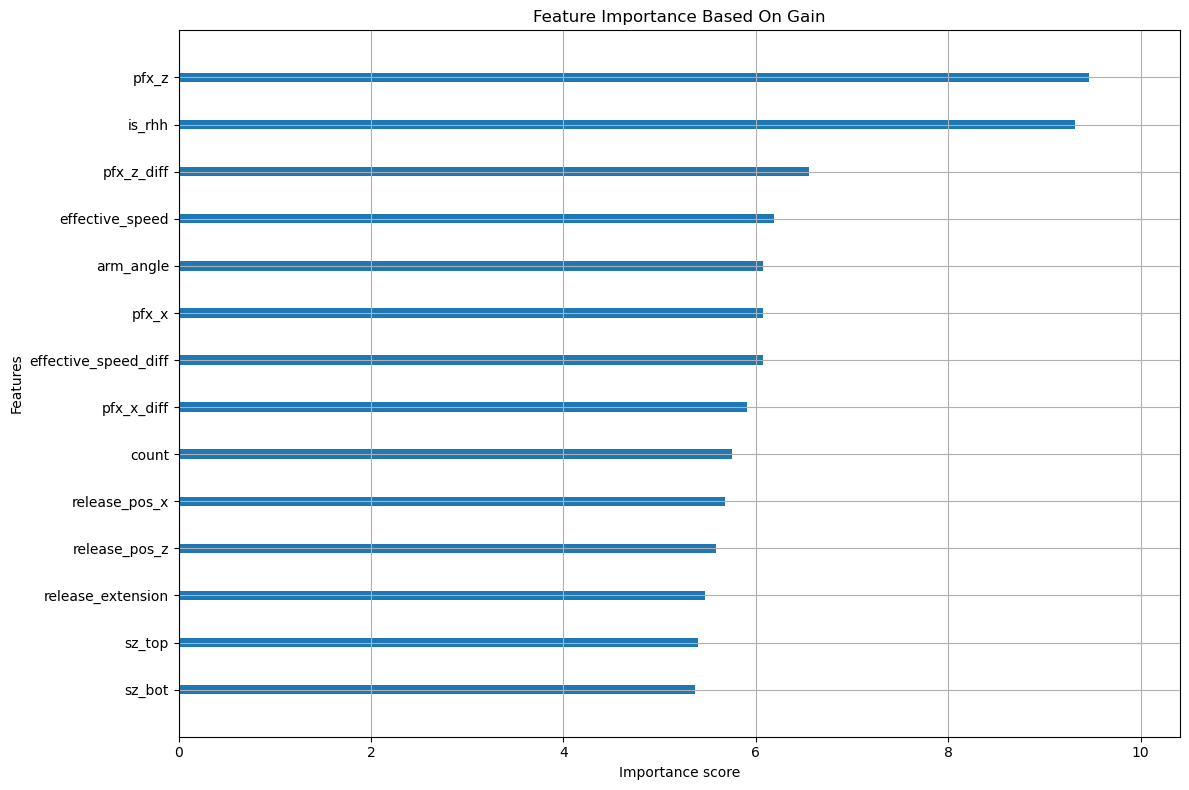

In [83]:
run_mlflow_pipeline(fair_experiment_id, X_train, y_train, X_valid, y_valid, pyfunc_path= pyfunc_model_path)

In [84]:
# The model is logged with an input example
pyfunc_model = mlflow.pyfunc.load_model(pyfunc_model_path)

data_predict_fair[["P(Foul)", "P(Fair)"]] = pyfunc_model.predict(data_predict_fair_X, params={"predict_method": "predict_proba"})
data_predict_fair["Fair_Pred"] = pyfunc_model.predict(data_predict_fair_X, params={"predict_method": "predict"})

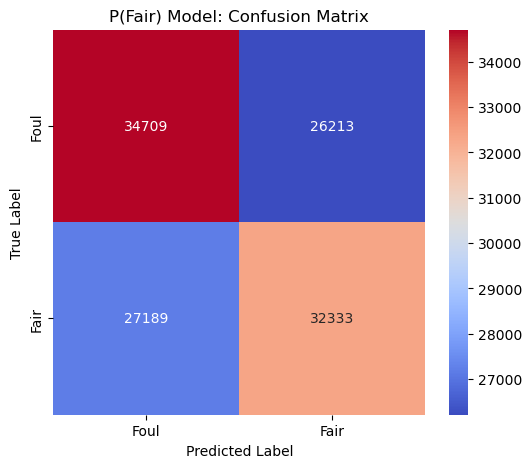

In [85]:
plot_confusion_mat(
    data_predict_fair["Fair_Event"], data_predict_fair["Fair_Pred"], ["Foul", "Fair"], ["Foul", "Fair"],
    plot_title= "P(Fair) Model: Confusion Matrix",
    save_path= None
)

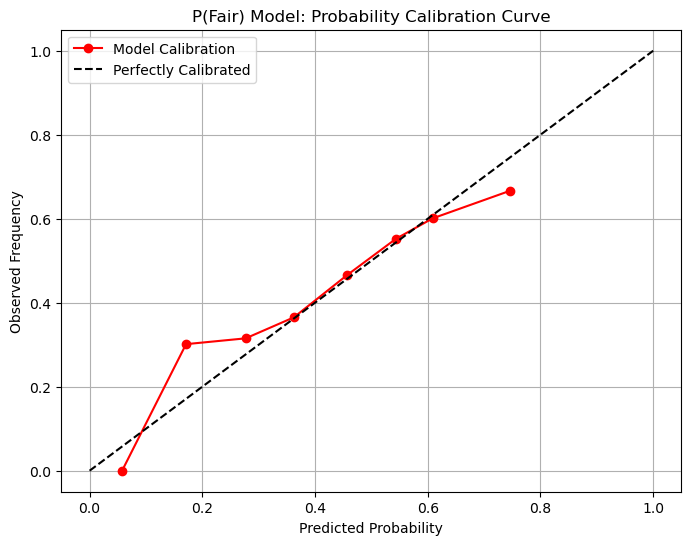

In [86]:
plot_probability_calibration_curve(
    data_predict_fair["Fair_Event"], data_predict_fair["P(Fair)"], 
    plot_title= "P(Fair) Model: Probability Calibration Curve",
    save_path= None
)

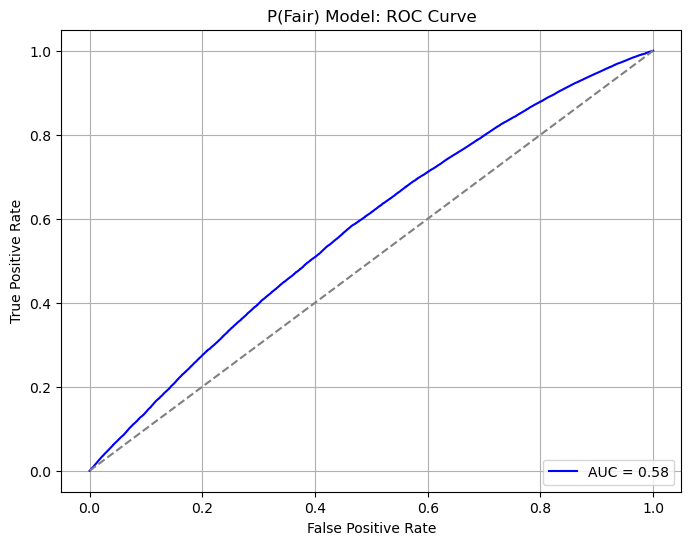

In [87]:
plot_roc_auc(
    data_predict_fair["Fair_Event"], data_predict_fair["P(Fair)"], plot_title = "P(Fair) Model: ROC Curve",
    save_path= None
)

## P(Launch Angle Bucket)

In [88]:
"""
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the P(Launch Angle Bucket) predictive modeling task under the Stuff+ project. "
    "This experiment contains the models built for modeling fair ball probability given contact (P(Fair) >= 0.5)."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "p-launch-prs",
    "team": "josh-stuff",
    "project_quarter": "Q2-2025",
    "mlflow.note.content": experiment_description,
}

experiment_name = "P(Launch Angle Bucket) Stuff"

# Create the Experiment, providing a unique name
p_launch_experiment = client.create_experiment(
    name= experiment_name, tags=experiment_tags
)
"""
print("")

In [89]:
# Use search_experiments() to search on the project_name tag key
launch_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'p-launch-prs'"
)

launch_experiment_id =  vars(launch_experiment[0])["_experiment_id"]

client.delete_experiment(launch_experiment_id)
client.restore_experiment(launch_experiment_id)

experiment = client.get_experiment(launch_experiment_id)
experiment

<Experiment: artifact_location='mlflow-artifacts:/995281553230585235', creation_time=1751079074156, experiment_id='995281553230585235', last_update_time=1751128823984, lifecycle_stage='active', name='P(Launch Angle Bucket) Stuff', tags={'mlflow.note.content': 'This is the P(Launch Angle Bucket) predictive '
                        'modeling task under the Stuff+ project. This '
                        'experiment contains the models built for modeling '
                        'fair ball probability given contact (P(Fair) >= 0.5).',
 'project_name': 'p-launch-prs',
 'project_quarter': 'Q2-2025',
 'team': 'josh-stuff'}>

In [90]:
data_concat_diff["launch_angle_bucket"] = np.where(
        data_concat_diff.launch_angle.astype(float).isna(), "N/A", np.where(
            data_concat_diff.launch_angle.astype(float) < 10, "GB", np.where(
                data_concat_diff.launch_angle.astype(float) < 25, "LD", np.where(
                    data_concat_diff.launch_angle.astype(float) < 50, "FB", "PU"
                )
            ) 
        )                                                                              
    )

data_concat_diff = add_ev_bucket(data_concat_diff)

data2025_diff["launch_angle_bucket"] = np.where(
        data2025_diff.launch_angle.astype(float).isna(), "N/A", np.where(
            data2025_diff.launch_angle.astype(float) < 10, "GB", np.where(
                data2025_diff.launch_angle.astype(float) < 25, "LD", np.where(
                    data2025_diff.launch_angle.astype(float) < 50, "FB", "PU"
                )
            ) 
        )                                                                              
    )

data2025_diff = add_ev_bucket(data2025_diff)

In [91]:
# Get P(Launch Angle Bucket) Data
p_launch_model_data = get_pitch_outcome_features(
    data_concat_diff[data_concat_diff.description_bucket == "hit_into_play"], 
    model_type= "bip_bin_stuff", added_features= diff_features
).drop("EV_bucket", axis = 1)

data_predict_launch = get_pitch_outcome_features(
    data2025_diff[data2025_diff.description_bucket == "hit_into_play"], 
    model_type= "bip_bin_stuff", added_features= diff_features
).drop("EV_bucket", axis = 1)

pyfunc_model_path = "../tmp/p_launch_stuff_diffs_xgb"

response_col = "launch_angle_bucket"
info_cols = ["batter", "pitcher", "game_year", "game_date", response_col]

# Refine into train, validation data
data_predict_launch_X = data_predict_launch.drop(info_cols, axis = 1)

p_launch_X = p_launch_model_data.drop(info_cols, axis = 1)
p_launch_y = p_launch_model_data[response_col]

X_train, X_valid, y_train, y_valid = train_test_split(p_launch_X, p_launch_y, train_size= 0.75, stratify = p_launch_y)

In [92]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((168336, 14), (168336,), (56112, 14), (56112,))

Name the project/task itself:  P(Launch Bucket) w/ Diffs
Choose problem type (classification/regression):  classification
Choose if Multiclass or Binary (Multiclass/Binary):  Multiclass
Choose model (XGBClassifier, LGBMClassifier, XGB-DMatrix, RandomForestClassifier, LogisticRegression):  XGBClassifier
Give all child run's artifact path:  model
Give the parent run it's own name:  P(Launch Bucket) vDiffs
Give the final model artifact's name:  final
Specify the number of trials to run with Optuna:  20


[I 2025-06-28 12:44:41,406] A new study created in memory with name: no-name-53dcc52a-8c84-4f6c-98df-73a26d6b1d08


Creating Optuna study...


[I 2025-06-28 12:45:08,371] Trial 0 finished with value: 1.2214086899599286 and parameters: {'n_estimators': 1502, 'eta': 0.04346791368729053, 'gamma': 0.019577969384048086, 'max_depth': 9, 'min_child_weight': 10, 'lambda': 0.8943627438119448, 'alpha': 0.0003129924118007577, 'subsample': 0.5384144518179053, 'colsample_bytree': 0.8362523179390018}. Best is trial 0 with value: 1.2214086899599286.


🏃 View run glamorous-kite-268 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/ad1af9bfed104987ae6526296aa37739
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:45:24,079] Trial 1 finished with value: 1.2200016591738796 and parameters: {'n_estimators': 916, 'eta': 0.0796046887990574, 'gamma': 5.2767422930534234e-05, 'max_depth': 6, 'min_child_weight': 6, 'lambda': 2.168190238115412e-05, 'alpha': 1.9810540887370258e-05, 'subsample': 0.8517682295462203, 'colsample_bytree': 0.8281036477199155}. Best is trial 1 with value: 1.2200016591738796.


🏃 View run intelligent-mole-335 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/2ea71e2346954ee48053f52e11fc445c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:45:34,337] Trial 2 finished with value: 1.2216199478690757 and parameters: {'n_estimators': 736, 'eta': 0.18193769394801085, 'gamma': 0.010998022447241483, 'max_depth': 6, 'min_child_weight': 8, 'lambda': 4.3568498233563144e-05, 'alpha': 0.15465183685015696, 'subsample': 0.648143157468903, 'colsample_bytree': 0.7954110078154856}. Best is trial 1 with value: 1.2200016591738796.


🏃 View run indecisive-robin-465 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/5ec6425aaca14675809e4bd1c1824886
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:45:52,123] Trial 3 finished with value: 1.220150502246096 and parameters: {'n_estimators': 1124, 'eta': 0.06202265366812628, 'gamma': 4.564255424813346e-05, 'max_depth': 7, 'min_child_weight': 4, 'lambda': 0.004447233381528133, 'alpha': 4.3900229581616904e-05, 'subsample': 0.8772876163234018, 'colsample_bytree': 0.9994511608308387}. Best is trial 1 with value: 1.2200016591738796.


🏃 View run omniscient-lark-276 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/b58a48e63cd04056b60878fa743b332e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:46:03,228] Trial 4 finished with value: 1.2356644592416182 and parameters: {'n_estimators': 145, 'eta': 0.02587367754946358, 'gamma': 1.088563561449779, 'max_depth': 4, 'min_child_weight': 8, 'lambda': 0.00034601262621778046, 'alpha': 0.07790978644408961, 'subsample': 0.4191467075236289, 'colsample_bytree': 0.4011948371202985}. Best is trial 1 with value: 1.2200016591738796.


🏃 View run fearless-pug-781 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/7b75ac23393844ef98d6fbd4107591da
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:46:35,569] Trial 5 finished with value: 1.2224878526535077 and parameters: {'n_estimators': 1474, 'eta': 0.03601377700662097, 'gamma': 0.46077188980450234, 'max_depth': 10, 'min_child_weight': 1, 'lambda': 4.670649730463041e-05, 'alpha': 0.010704759139759478, 'subsample': 0.78528623375408, 'colsample_bytree': 0.8656718951703293}. Best is trial 1 with value: 1.2200016591738796.


🏃 View run inquisitive-kite-401 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/0cc02de67e8f4a92a91c8abeef5d6b49
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:46:56,649] Trial 6 finished with value: 1.2197674072705273 and parameters: {'n_estimators': 764, 'eta': 0.06439506206390216, 'gamma': 2.731170288373338, 'max_depth': 6, 'min_child_weight': 6, 'lambda': 7.245853727067321e-05, 'alpha': 0.0013121823797908206, 'subsample': 0.45389843137827734, 'colsample_bytree': 0.7516005092470679}. Best is trial 6 with value: 1.2197674072705273.


🏃 View run indecisive-frog-28 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/caab9b8b8ee641498cc56df7096ef3f4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:47:28,786] Trial 7 finished with value: 1.21974632524282 and parameters: {'n_estimators': 1268, 'eta': 0.03227163661720018, 'gamma': 0.00883481931701623, 'max_depth': 6, 'min_child_weight': 6, 'lambda': 0.8262542905623363, 'alpha': 0.00023617576160596965, 'subsample': 0.7143986820991268, 'colsample_bytree': 0.8446904193130793}. Best is trial 7 with value: 1.21974632524282.


🏃 View run dazzling-moth-310 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/280663ca1f9b49ea86da6f76e260c9c7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:47:41,515] Trial 8 finished with value: 1.2211130418118232 and parameters: {'n_estimators': 1068, 'eta': 0.15168559190601902, 'gamma': 0.3658504973318804, 'max_depth': 7, 'min_child_weight': 8, 'lambda': 0.04570557431938804, 'alpha': 0.029749104062598047, 'subsample': 0.8165555041840467, 'colsample_bytree': 0.9012991955288943}. Best is trial 7 with value: 1.21974632524282.


🏃 View run fearless-duck-881 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/3525c323521e47cea0c7935db29c26d5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:48:16,982] Trial 9 finished with value: 1.2215385753504129 and parameters: {'n_estimators': 929, 'eta': 0.11022983528245046, 'gamma': 0.03336426772925205, 'max_depth': 2, 'min_child_weight': 1, 'lambda': 0.022734530366318628, 'alpha': 0.00039504044744070286, 'subsample': 0.8488350695214515, 'colsample_bytree': 0.8321858420774588}. Best is trial 7 with value: 1.21974632524282.


🏃 View run luminous-bug-917 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/8381bad14c674d348367438e02b07a00
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:49:40,824] Trial 10 finished with value: 1.2227916584946323 and parameters: {'n_estimators': 1953, 'eta': 0.011662754189596277, 'gamma': 0.0004844913471942367, 'max_depth': 3, 'min_child_weight': 3, 'lambda': 0.6194111833619773, 'alpha': 0.6755241452218488, 'subsample': 0.996436378290906, 'colsample_bytree': 0.5679137864545344}. Best is trial 7 with value: 1.21974632524282.


🏃 View run nosy-stork-657 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/f956a5170fb743d0a3c12d7335504eb9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:50:06,349] Trial 11 finished with value: 1.2237553642059424 and parameters: {'n_estimators': 451, 'eta': 0.01922876114208649, 'gamma': 4.904557293472634, 'max_depth': 5, 'min_child_weight': 7, 'lambda': 0.00041062217715091175, 'alpha': 0.00079621833470603, 'subsample': 0.34373677255573337, 'colsample_bytree': 0.6552808778947494}. Best is trial 7 with value: 1.21974632524282.


🏃 View run lyrical-eel-747 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/75750ecfe0fd4a30a641c30282edbdb8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:50:18,199] Trial 12 finished with value: 1.2234030768554078 and parameters: {'n_estimators': 1405, 'eta': 0.2808076971209581, 'gamma': 0.0014772885765769483, 'max_depth': 8, 'min_child_weight': 5, 'lambda': 0.0007770246664464178, 'alpha': 7.740676430619741, 'subsample': 0.5951026826551108, 'colsample_bytree': 0.6843893513342306}. Best is trial 7 with value: 1.21974632524282.


🏃 View run thundering-perch-64 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/c96e1632788f49b4af8f35caec26b684
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:50:50,873] Trial 13 finished with value: 1.2218047730122807 and parameters: {'n_estimators': 523, 'eta': 0.018796514799405206, 'gamma': 0.07684691668149655, 'max_depth': 5, 'min_child_weight': 3, 'lambda': 0.09020313308123228, 'alpha': 0.0015871135474634672, 'subsample': 0.4859395246219721, 'colsample_bytree': 0.5284517861377447}. Best is trial 7 with value: 1.21974632524282.


🏃 View run beautiful-shark-998 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/42e18b72bccf48d099f19b5146e88ac8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:51:16,028] Trial 14 finished with value: 1.2202438097987092 and parameters: {'n_estimators': 1785, 'eta': 0.05991698880513952, 'gamma': 0.0010980469781194273, 'max_depth': 4, 'min_child_weight': 10, 'lambda': 0.004663639333429547, 'alpha': 8.773433536924221e-05, 'subsample': 0.6841911721645322, 'colsample_bytree': 0.7253151295240526}. Best is trial 7 with value: 1.21974632524282.


🏃 View run magnificent-kit-28 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/d85cbaeddd3c4c5cbad0b45d81110cbc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:52:03,735] Trial 15 finished with value: 1.2222518458459006 and parameters: {'n_estimators': 1295, 'eta': 0.03758189729286107, 'gamma': 4.255452182597057, 'max_depth': 8, 'min_child_weight': 6, 'lambda': 1.1022902277420823e-05, 'alpha': 0.00455727780843422, 'subsample': 0.7300012919590162, 'colsample_bytree': 0.30377618109445853}. Best is trial 7 with value: 1.21974632524282.


🏃 View run sneaky-snail-711 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/2450c48673254c9d842860f33791fe02
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:52:18,900] Trial 16 finished with value: 1.2217807501409195 and parameters: {'n_estimators': 645, 'eta': 0.09104806488433219, 'gamma': 1.0158468847887707e-05, 'max_depth': 7, 'min_child_weight': 5, 'lambda': 0.0001379030992708312, 'alpha': 1.0276362986722512e-05, 'subsample': 0.40817478740577967, 'colsample_bytree': 0.9596397276223136}. Best is trial 7 with value: 1.21974632524282.


🏃 View run clean-robin-499 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/60309612148f4115ad52e5d0798df3e8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:52:38,484] Trial 17 finished with value: 1.2218637154371605 and parameters: {'n_estimators': 292, 'eta': 0.025995368791920055, 'gamma': 0.12237908663852025, 'max_depth': 5, 'min_child_weight': 3, 'lambda': 0.0015207844178881421, 'alpha': 0.00013298507294657658, 'subsample': 0.5680016990835788, 'colsample_bytree': 0.7493653665077284}. Best is trial 7 with value: 1.21974632524282.


🏃 View run rogue-wren-151 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/da04fd1071884c3e9a5d07737ed63b55
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:53:43,424] Trial 18 finished with value: 1.2204067472441786 and parameters: {'n_estimators': 775, 'eta': 0.011522755361308385, 'gamma': 0.002458510344573554, 'max_depth': 8, 'min_child_weight': 7, 'lambda': 0.2307791145537133, 'alpha': 0.0028052927747393586, 'subsample': 0.3283757550773582, 'colsample_bytree': 0.5898798216295484}. Best is trial 7 with value: 1.21974632524282.


🏃 View run unequaled-stoat-592 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/b5f7f1dc56ae460f928102dcbc3bb4b1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


[I 2025-06-28 12:54:13,994] Trial 19 finished with value: 1.2203388654343852 and parameters: {'n_estimators': 1671, 'eta': 0.050269105637744275, 'gamma': 0.0002728419160659704, 'max_depth': 4, 'min_child_weight': 0, 'lambda': 0.012411248995257872, 'alpha': 0.011380250842178741, 'subsample': 0.47957678600572956, 'colsample_bytree': 0.9278728085923589}. Best is trial 7 with value: 1.21974632524282.


🏃 View run gregarious-crow-704 at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/96308986934241c8b93c502259bb58e8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235
Logging best parameters and training final model...
Creating feature importance plot...
Feature importance plot saved as ../model_feature_importances.png


2025/06/28 12:55:22 INFO mlflow.pyfunc: Validating input example against model signature


🏃 View run P(Launch Bucket) vDiffs at: http://127.0.0.1:8080/#/experiments/995281553230585235/runs/802581f40ec34e6eb47f450c294bf179
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/995281553230585235


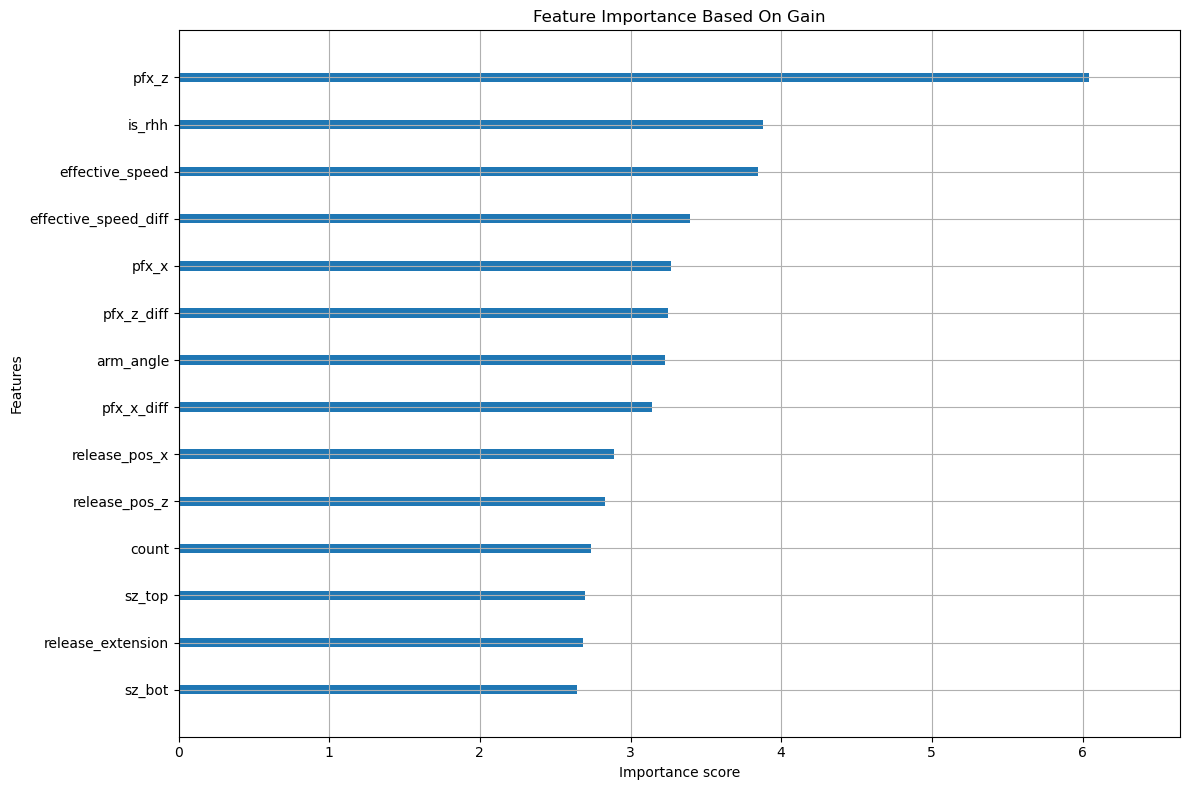

In [94]:
run_mlflow_pipeline(launch_experiment_id, X_train, y_train, X_valid, y_valid, pyfunc_path= pyfunc_model_path)

In [95]:
pyfunc_model_path = "../tmp/p_launch_stuff_diffs_xgb"

pyfunc_model = mlflow.pyfunc.load_model(pyfunc_model_path)

data_predict_launch[["P(GB)", "P(LD)", "P(FB)", "P(PU)"]] = pyfunc_model.predict(data_predict_launch_X, params={"predict_method": "predict_proba"})
data_predict_launch["Launch_Pred"] = pyfunc_model.predict(data_predict_launch_X, params={"predict_method": "predict"})

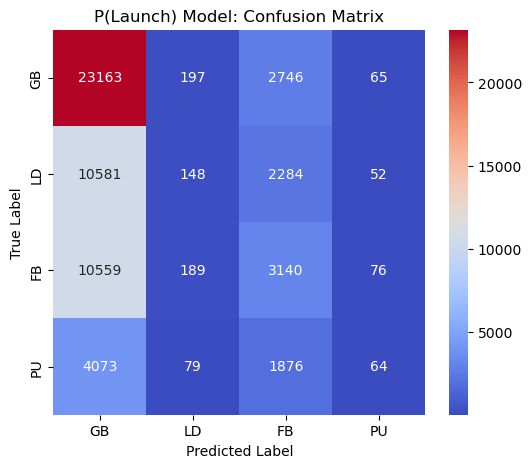

In [96]:
plot_confusion_mat(
    data_predict_launch["launch_angle_bucket"], data_predict_launch["Launch_Pred"], 
    ["GB", "LD", "FB", "PU"], ["GB", "LD", "FB", "PU"],
    plot_title= "P(Launch) Model: Confusion Matrix", 
    save_path= None
)

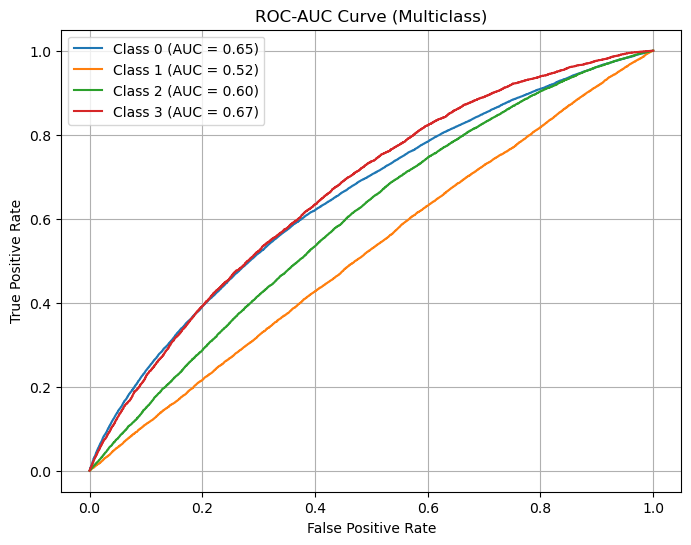

In [99]:
plot_roc_auc_multiclass(
    data_predict_launch["launch_angle_bucket"], data_predict_launch[["P(GB)", "P(LD)", "P(FB)", "P(PU)"]].values, 4,
    save_path= None
)

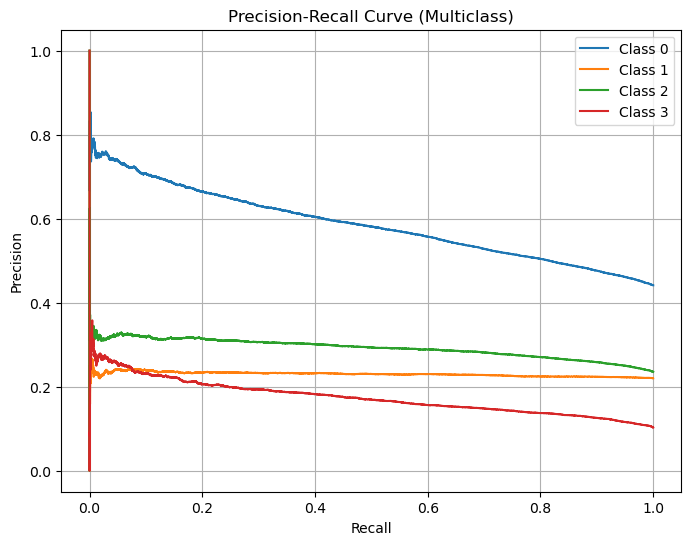

In [100]:
plot_precision_recall(
    data_predict_launch["launch_angle_bucket"], data_predict_launch[["P(GB)", "P(LD)", "P(FB)", "P(PU)"]].values, 4,
    save_path= None
)

## P(EV Bucket)

In [101]:
"""
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the P(Exit Velocity Bucket) predictive modeling task under the Stuff+ project. "
    "This experiment contains the models built for modeling fair ball probability given contact (P(Fair) >= 0.5)."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "p-ev-prs",
    "team": "josh-stuff",
    "project_quarter": "Q2-2025",
    "mlflow.note.content": experiment_description,
}

experiment_name = "P(EV Bucket) Stuff"

# Create the Experiment, providing a unique name
p_ev_experiment = client.create_experiment(
    name= experiment_name, tags=experiment_tags
)
"""
print("")

In [102]:
# Use search_experiments() to search on the project_name tag key
ev_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'p-ev-prs'"
)

ev_experiment_id =  vars(ev_experiment[0])["_experiment_id"]

client.delete_experiment(ev_experiment_id)
client.restore_experiment(ev_experiment_id)

experiment = client.get_experiment(ev_experiment_id)
experiment

<Experiment: artifact_location='mlflow-artifacts:/724063170462233953', creation_time=1751081636821, experiment_id='724063170462233953', last_update_time=1751129989492, lifecycle_stage='active', name='P(EV Bucket) Stuff', tags={'mlflow.note.content': 'This is the P(Exit Velocity Bucket) predictive '
                        'modeling task under the Stuff+ project. This '
                        'experiment contains the models built for modeling '
                        'fair ball probability given contact (P(Fair) >= 0.5).',
 'project_name': 'p-ev-prs',
 'project_quarter': 'Q2-2025',
 'team': 'josh-stuff'}>

In [103]:
# Get P(Launch Angle Bucket) Data
p_ev_model_data = get_pitch_outcome_features(
    data_concat_diff[data_concat_diff.description_bucket == "hit_into_play"], 
    model_type= "bip_bin_stuff", added_features= diff_features
).drop("launch_angle_bucket", axis = 1)

data_predict_ev = get_pitch_outcome_features(
    data2025_diff[data2025_diff.description_bucket == "hit_into_play"], 
    model_type= "bip_bin_stuff", added_features= diff_features
).drop("launch_angle_bucket", axis = 1)

pyfunc_model_path = "../tmp/p_ev_stuff_diffs_xgb"

response_col = "EV_bucket"
info_cols = ["batter", "pitcher", "game_year", "game_date", response_col]

# Refine into train, validation data
data_predict_ev_X = data_predict_ev.drop(info_cols, axis = 1)

p_ev_X = p_ev_model_data.drop(info_cols, axis = 1)
p_ev_y = p_ev_model_data[response_col]

X_train, X_valid, y_train, y_valid = train_test_split(p_ev_X, p_ev_y, train_size= 0.75, stratify = p_ev_y)

In [104]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((168336, 14), (168336,), (56112, 14), (56112,))

Name the project/task itself:  P(EV Bucket) with Diffs
Choose problem type (classification/regression):  classification
Choose if Multiclass or Binary (Multiclass/Binary):  Multiclass
Choose model (XGBClassifier, LGBMClassifier, XGB-DMatrix, RandomForestClassifier, LogisticRegression):  XGBClassifier
Give all child run's artifact path:  model
Give the parent run it's own name:  P(EV Bucket) vDiffs
Give the final model artifact's name:  final
Specify the number of trials to run with Optuna:  20


[I 2025-06-28 13:00:26,797] A new study created in memory with name: no-name-fee1e641-c45e-48a8-98a0-ece45a3a3522


Creating Optuna study...


[I 2025-06-28 13:00:55,937] Trial 0 finished with value: 1.4137761348473459 and parameters: {'n_estimators': 246, 'eta': 0.01073076523928373, 'gamma': 0.011323895767324583, 'max_depth': 5, 'min_child_weight': 5, 'lambda': 0.0002828433672049762, 'alpha': 3.8344812615793122, 'subsample': 0.5886047006279298, 'colsample_bytree': 0.40220192944251737}. Best is trial 0 with value: 1.4137761348473459.


🏃 View run fearless-moth-751 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/9086c1df3f154019924c688da7ceb3d6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:02:21,280] Trial 1 finished with value: 1.4022203139217317 and parameters: {'n_estimators': 1786, 'eta': 0.022549555181756595, 'gamma': 0.00041874231246424106, 'max_depth': 3, 'min_child_weight': 2, 'lambda': 1.8150802228851746e-05, 'alpha': 6.762784332678556, 'subsample': 0.34955650129361476, 'colsample_bytree': 0.6737814764857593}. Best is trial 1 with value: 1.4022203139217317.


🏃 View run painted-hog-235 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/092093be3dd842e5b2d922c29768aeb6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:03:36,721] Trial 2 finished with value: 1.404515225823403 and parameters: {'n_estimators': 1577, 'eta': 0.021237255436431242, 'gamma': 3.97694933568834e-05, 'max_depth': 2, 'min_child_weight': 8, 'lambda': 0.009861644338284948, 'alpha': 0.0003132246709671689, 'subsample': 0.3718896425373794, 'colsample_bytree': 0.5573082883620695}. Best is trial 1 with value: 1.4022203139217317.


🏃 View run capricious-croc-363 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/13d583fb2ad34f9698d424322b4655d5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:03:48,780] Trial 3 finished with value: 1.4053343691839408 and parameters: {'n_estimators': 964, 'eta': 0.20456052719953371, 'gamma': 0.0002499187997956892, 'max_depth': 7, 'min_child_weight': 5, 'lambda': 1.9155285810333576e-05, 'alpha': 0.002272041814481599, 'subsample': 0.5821807689856404, 'colsample_bytree': 0.38590072511300466}. Best is trial 1 with value: 1.4022203139217317.


🏃 View run chill-bee-647 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/b4bdc981f2654c5283d2f244ad6bcab3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:04:00,399] Trial 4 finished with value: 1.4080081865731482 and parameters: {'n_estimators': 1512, 'eta': 0.19346155971693793, 'gamma': 0.00014716368984805768, 'max_depth': 8, 'min_child_weight': 9, 'lambda': 1.1966514986587725e-05, 'alpha': 0.09519329461174288, 'subsample': 0.3439570981649125, 'colsample_bytree': 0.6227996002231888}. Best is trial 1 with value: 1.4022203139217317.


🏃 View run hilarious-smelt-259 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/2b79ae2550eb465894b5c2b7ed98932b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:05:34,214] Trial 5 finished with value: 1.4021511813646121 and parameters: {'n_estimators': 1231, 'eta': 0.010316046063576612, 'gamma': 0.2176991306122556, 'max_depth': 4, 'min_child_weight': 10, 'lambda': 0.0008530854591296058, 'alpha': 0.0014702164944507626, 'subsample': 0.4864932941835806, 'colsample_bytree': 0.8373375015426092}. Best is trial 5 with value: 1.4021511813646121.


🏃 View run nervous-shark-949 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/c2f9af5db8e046b8ad93f3fef51820c5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:05:58,319] Trial 6 finished with value: 1.4021469899350367 and parameters: {'n_estimators': 1132, 'eta': 0.16726017064707385, 'gamma': 1.3057512411610264, 'max_depth': 3, 'min_child_weight': 2, 'lambda': 0.011087480900691874, 'alpha': 8.931129569349103, 'subsample': 0.5460200038667397, 'colsample_bytree': 0.6575311654730039}. Best is trial 6 with value: 1.4021469899350367.


🏃 View run unique-sponge-252 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/3fb5e2adf2564b0b99954ec6a03c1bc6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:06:29,709] Trial 7 finished with value: 1.4019212730041652 and parameters: {'n_estimators': 602, 'eta': 0.04330340139133281, 'gamma': 0.037378148820093354, 'max_depth': 4, 'min_child_weight': 8, 'lambda': 0.015721158603247146, 'alpha': 0.04650950503417361, 'subsample': 0.6027573966806639, 'colsample_bytree': 0.8447052554985641}. Best is trial 7 with value: 1.4019212730041652.


🏃 View run silent-bass-840 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/32ede9be0e5e421680d5382e48215a4b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:06:58,303] Trial 8 finished with value: 1.4017988121080245 and parameters: {'n_estimators': 1990, 'eta': 0.05065255720262313, 'gamma': 0.05074138005791803, 'max_depth': 6, 'min_child_weight': 4, 'lambda': 0.0001363063693787971, 'alpha': 0.2728225293950646, 'subsample': 0.804272325848757, 'colsample_bytree': 0.39614519128704206}. Best is trial 8 with value: 1.4017988121080245.


🏃 View run likeable-sloth-921 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/cc0fe7253e7c495da8d06c043e1aa638
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:07:44,083] Trial 9 finished with value: 1.402473972891361 and parameters: {'n_estimators': 581, 'eta': 0.015221056706441744, 'gamma': 0.4007118388000192, 'max_depth': 6, 'min_child_weight': 6, 'lambda': 0.009136127466760015, 'alpha': 0.008200399128823165, 'subsample': 0.4311860047216137, 'colsample_bytree': 0.42048748014050863}. Best is trial 8 with value: 1.4017988121080245.


🏃 View run enthused-goat-64 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/2a2e367ec420428087be7c20c86c4dd3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:08:09,955] Trial 10 finished with value: 1.4070213403885292 and parameters: {'n_estimators': 1995, 'eta': 0.08030907159513982, 'gamma': 0.0025832889669263714, 'max_depth': 10, 'min_child_weight': 0, 'lambda': 0.3384770928171537, 'alpha': 4.449259431033728e-05, 'subsample': 0.8776895840481512, 'colsample_bytree': 0.30883969296787706}. Best is trial 8 with value: 1.4017988121080245.


🏃 View run sassy-rook-41 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/b45ad769399340039761c0ca053f6788
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:08:42,001] Trial 11 finished with value: 1.401281921295928 and parameters: {'n_estimators': 646, 'eta': 0.049055126701254156, 'gamma': 0.032943949361037186, 'max_depth': 5, 'min_child_weight': 7, 'lambda': 0.280235521927778, 'alpha': 0.12554867800959033, 'subsample': 0.768270135360559, 'colsample_bytree': 0.991019664698525}. Best is trial 11 with value: 1.401281921295928.


🏃 View run carefree-rook-764 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/50e2a4d8e7764b4da3e0f1698ce75843
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:09:03,401] Trial 12 finished with value: 1.4016440456369201 and parameters: {'n_estimators': 649, 'eta': 0.05697244705368581, 'gamma': 0.05534362488685056, 'max_depth': 8, 'min_child_weight': 6, 'lambda': 0.9135102081817565, 'alpha': 0.3264068441070751, 'subsample': 0.7922311885187864, 'colsample_bytree': 0.9996356764477853}. Best is trial 11 with value: 1.401281921295928.


🏃 View run gifted-lamb-348 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/f446fe9fb190404eb0ccaa67c721f6ee
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:09:27,026] Trial 13 finished with value: 1.4006674338484806 and parameters: {'n_estimators': 641, 'eta': 0.08703841908220744, 'gamma': 4.448615818775902, 'max_depth': 9, 'min_child_weight': 7, 'lambda': 0.8440219106066527, 'alpha': 0.3791848712844417, 'subsample': 0.7465460669690303, 'colsample_bytree': 0.9989049325132715}. Best is trial 13 with value: 1.4006674338484806.


🏃 View run rogue-squid-127 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/471217ae89cf4a5bb7c406a6083f8911
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:09:40,934] Trial 14 finished with value: 1.4009085530352392 and parameters: {'n_estimators': 208, 'eta': 0.09946077687765961, 'gamma': 4.769244318390067, 'max_depth': 10, 'min_child_weight': 7, 'lambda': 0.09309479107957633, 'alpha': 0.8629501901987875, 'subsample': 0.7144370424901665, 'colsample_bytree': 0.9961517264867893}. Best is trial 13 with value: 1.4006674338484806.


🏃 View run sincere-ape-633 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/6b4d39f7cd644d5cb973198170d0c24a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:09:52,159] Trial 15 finished with value: 1.401343458224881 and parameters: {'n_estimators': 137, 'eta': 0.11411013841717665, 'gamma': 4.867525576486904, 'max_depth': 10, 'min_child_weight': 10, 'lambda': 0.08076257598388914, 'alpha': 1.221057815863099, 'subsample': 0.9797026547484409, 'colsample_bytree': 0.8792114006036849}. Best is trial 13 with value: 1.4006674338484806.


🏃 View run charming-fox-490 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/9b9a59659c2e4d2b8162dd26d0100f5d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:10:09,988] Trial 16 finished with value: 1.4004929608139864 and parameters: {'n_estimators': 347, 'eta': 0.11207843491979648, 'gamma': 4.530651656399823, 'max_depth': 9, 'min_child_weight': 8, 'lambda': 0.10155524541895862, 'alpha': 1.0519345987977644, 'subsample': 0.697821685674697, 'colsample_bytree': 0.9198879082228043}. Best is trial 16 with value: 1.4004929608139864.


🏃 View run skillful-asp-648 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/5db17df7ddb64a69bf0103db4e43c463
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:10:21,360] Trial 17 finished with value: 1.4064781548864214 and parameters: {'n_estimators': 430, 'eta': 0.28992500577864827, 'gamma': 0.8551296695706587, 'max_depth': 8, 'min_child_weight': 8, 'lambda': 0.052443688010118575, 'alpha': 0.017910328421697007, 'subsample': 0.7185873019889093, 'colsample_bytree': 0.746261393610715}. Best is trial 16 with value: 1.4004929608139864.


🏃 View run whimsical-hare-734 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/896a066516b14f56a0662cf9bd177ccc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:10:34,181] Trial 18 finished with value: 1.402945830223715 and parameters: {'n_estimators': 919, 'eta': 0.13213570895075932, 'gamma': 1.2180491492457746, 'max_depth': 9, 'min_child_weight': 3, 'lambda': 0.877142773010187, 'alpha': 1.7014284379594373, 'subsample': 0.9032201502972741, 'colsample_bytree': 0.9138360746600904}. Best is trial 16 with value: 1.4004929608139864.


🏃 View run unequaled-deer-584 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/e7e0dce6a833457796c85dd496eb002a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


[I 2025-06-28 13:10:53,969] Trial 19 finished with value: 1.4031936858833338 and parameters: {'n_estimators': 836, 'eta': 0.08111537355183872, 'gamma': 0.1859257821062793, 'max_depth': 9, 'min_child_weight': 9, 'lambda': 0.002163662257002882, 'alpha': 0.488124651242732, 'subsample': 0.6567399492690686, 'colsample_bytree': 0.7751360802130909}. Best is trial 16 with value: 1.4004929608139864.


🏃 View run big-mink-511 at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/5e73a902cee54227bab191567aafddf7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953
Logging best parameters and training final model...
Creating feature importance plot...
Feature importance plot saved as ../model_feature_importances.png


2025/06/28 13:11:14 INFO mlflow.pyfunc: Validating input example against model signature


🏃 View run P(EV Bucket) vDiffs at: http://127.0.0.1:8080/#/experiments/724063170462233953/runs/69dc353c22ef474795418d6c105d1a31
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/724063170462233953


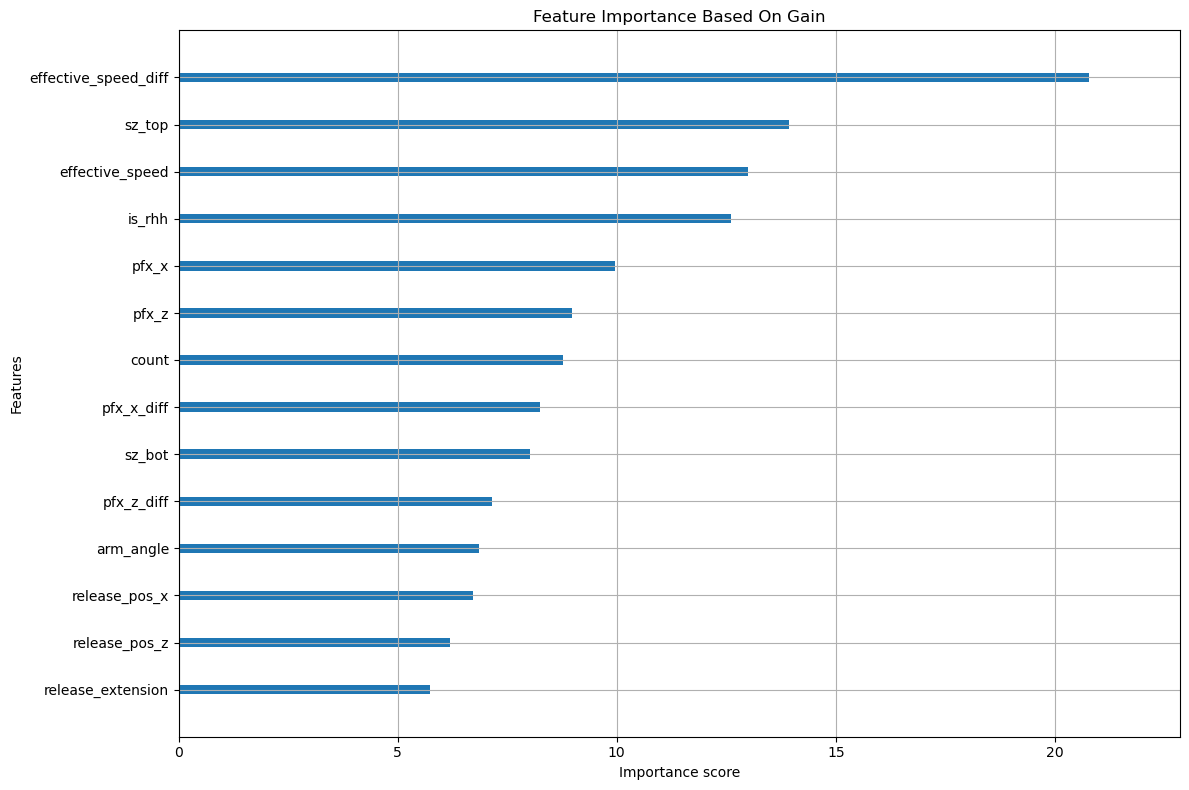

In [105]:
run_mlflow_pipeline(ev_experiment_id, X_train, y_train, X_valid, y_valid, pyfunc_path= pyfunc_model_path)

In [106]:
pyfunc_model_path = "../tmp/p_ev_stuff_diffs_xgb"

pyfunc_model = mlflow.pyfunc.load_model(pyfunc_model_path)

data_predict_ev[["P(<90)", "P(95_100)", "P(90_95)", "P(100_105)", "P(>105)"]] = pyfunc_model.predict(
    data_predict_ev_X, params={"predict_method": "predict_proba"})
data_predict_ev["EV_Pred"] = pyfunc_model.predict(data_predict_ev_X, params={"predict_method": "predict"})

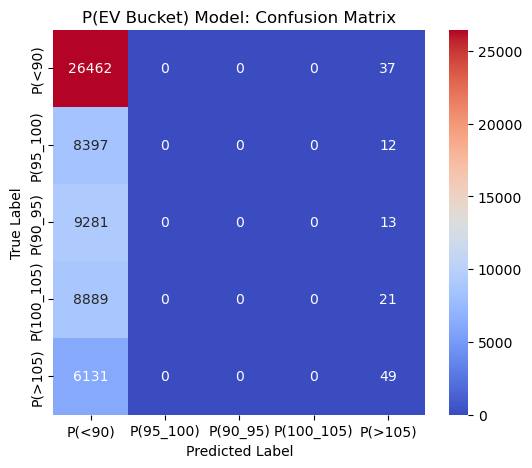

In [107]:
plot_confusion_mat(
    data_predict_ev["EV_bucket"], data_predict_ev["EV_Pred"], 
    ["P(<90)", "P(95_100)", "P(90_95)", "P(100_105)", "P(>105)"], ["P(<90)", "P(95_100)", "P(90_95)", "P(100_105)", "P(>105)"],
    plot_title= "P(EV Bucket) Model: Confusion Matrix", 
    save_path= None
)

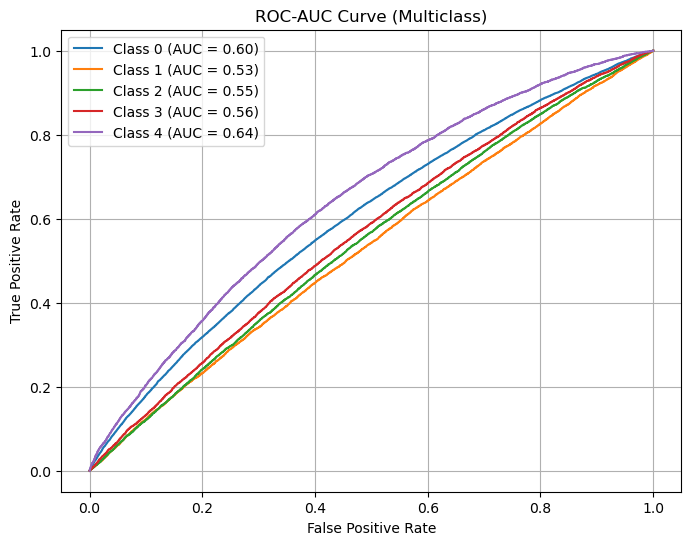

In [108]:
plot_roc_auc_multiclass(
    data_predict_ev["EV_bucket"], data_predict_ev[["P(<90)", "P(95_100)", "P(90_95)", "P(100_105)", "P(>105)"]].values, 5,
    save_path= None
)

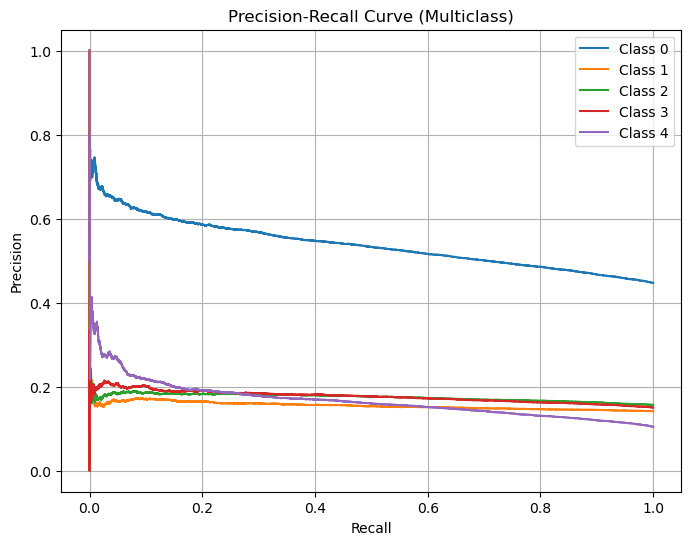

In [109]:
plot_precision_recall(
    data_predict_ev["EV_bucket"], data_predict_ev[["P(<90)", "P(95_100)", "P(90_95)", "P(100_105)", "P(>105)"]].values, 5,
    save_path= None
)

# Prediction Aggregations

In [ ]:
pyfunc_model_path = "../tmp/p_swing_stuff_diffs_xgb"
swing_model = mlflow.pyfunc.load_model(pyfunc_model_path)

pyfunc_model_path = "../tmp/p_take_stuff_diffs_xgb"
take_outcome_model = mlflow.pyfunc.load_model(pyfunc_model_path)

pyfunc_model_path = "../tmp/p_contact_stuff_diffs_xgb"
contact_model = mlflow.pyfunc.load_model(pyfunc_model_path)

pyfunc_model_path = "../tmp/p_fair_stuff_diffs_xgb"
fair_model = mlflow.pyfunc.load_model(pyfunc_model_path)

pyfunc_model_path = "../tmp/p_launch_stuff_diffs_xgb"
launch_bucket_model = mlflow.pyfunc.load_model(pyfunc_model_path)

pyfunc_model_path = "../tmp/p_ev_stuff_diffs_xgb"
ev_bucket_model = mlflow.pyfunc.load_model(pyfunc_model_path)

In [27]:
run_values = get_average_run_value_per_bip_bucket(data_concat, True)

In [ ]:
data2025.groupby(["game_year", "pitcher"])['pitch_type'] \
                     .agg(get_primary_pitch).reset_index(name='primary_pitch')